---
# 0️⃣ Data Load

In [116]:
import numpy as np
import pandas as pd

from pandas.api.types import is_string_dtype, is_numeric_dtype
from moda.dataprep import raw_to_ts, ts_to_range
import lasio
import math
import joypy
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import mode

from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from dtaidistance import dtw
from dtaidistance import clustering

import time
from datetime import datetime, date

import urllib
from urllib.error import URLError, HTTPError
import os
from dateutil import parser

import seaborn as sns
import matplotlib as mpl
import matplotlib.cbook as cbook
import matplotlib.colors as mcolors
import matplotlib.font_manager as fm
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon

import koreanize_matplotlib
from highlight_text import fig_text, ax_text

import calmap
import calplot
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
import dataframe_image as dfi
from PIL import Image

## 경고메세지 숨기기
import warnings
warnings.filterwarnings(action='ignore')
## 숨겼던 경고메세지 다시 보이게하기
# warnings.filterwarnings(action='default')

## 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

%matplotlib inline
# pd.options.display.float_format='{:.2f}'.format

## -------------------------------------------------------------------------------- ## ->|
YJPATH = r"F:/YJ-RnDnote-WS/data/"
YJPATH3 = r'F:/YJ-format-230125/data/'
NCPATH = r"C:/app/Git-WS/2022/local-yjtest/23-YJ-RnDnote/YJH-RnDnote-WS/data/"
INDIR = r"001_pbp_raw/" 
OUTDIR = r"002_pbp_interim/"
OUTDIR3 = r'interim/'

pf = pd.read_csv('F:/YJ-RnDnote-WS/data/003_kbo_record_raw/KBO-record-c-0122.csv', encoding='utf-8')
color = pd.read_csv("F:/YJ-format-230125/data/team_colors3.csv", encoding='cp949')

df = pd.read_csv(YJPATH + OUTDIR + r'pbp-interim-2023-02-18.csv', encoding='cp949', low_memory=False)
df["game_date"] = pd.to_datetime(df.game_date, format='%Y-%m-%d')

def two_digit(n): 
    return f"{n:02d}"
df['bs_cnt']=df['bs_cnt'].apply(two_digit)

def six_digit(n): 
    return f"{n:06d}"
df['bso_rcnt']=df['bso_rcnt'].apply(six_digit)

df.drop_duplicates(inplace=True)
df.shape

(1308468, 189)

---
# 1️⃣ Zone Data Setting

In [117]:
df.sort_values('gid-intot-panum-pitnum', ascending=True)
df=df[df['zone101_new']!=99]
data=df.copy()
data = data[data['yy']==2022]

## **************************************************************************************************** ## ->|
data.sort_values('gid-intot-panum-pitnum', ascending=True)
data = data.groupby(['yy', 'catcher', 'catcher_ID', 'cid', 'zone101', 'zone101_new']).agg(num_pitch=('gid-intot-panum-pitnum', 'nunique')
                                                                                     , p_emblem=('p_emblem','last')
                                                                                     , p_team=('p_team','last')).reset_index()
    
## **************************************************************************************************** ## ->|
color2 = color[['p_emblem', 'team_color', 'order_num']].copy()
data = pd.merge(left=data, right=color2, how='left', on=['p_emblem'], sort=False)
data = data[['yy', 'p_emblem', 'catcher', 'catcher_ID', 'cid', 'team_color', 'zone101', 'zone101_new', 'p_team','order_num', 'num_pitch']]

total_pitch = data.groupby(['yy', 'cid', 'catcher', 'catcher_ID', 'order_num', 'p_team'])['num_pitch'].sum().reset_index()
total_pitch.rename(columns={'num_pitch':'total_pitch'}, inplace=True)

data = pd.merge(data, total_pitch, on=['yy', 'cid', 'catcher', 'catcher_ID', 'order_num', 'p_team'], how='left')
data['pct_pitch'] = data['num_pitch']/data['total_pitch']
data = data.sort_values(by=['order_num', 'total_pitch'], ascending=(True,False))
order_team = total_pitch.sort_values(by=['order_num', 'total_pitch'], ascending=(True,False))

## **************************************************************************************************** ## ->|
order_team['rank']=order_team.groupby(['yy', 'order_num'])['total_pitch'].rank(method='min', ascending=False)
order_team['rank'] = np.where(order_team['rank']>=5, 5.0, order_team['rank'])
order_team = order_team.sort_values(by=['yy', 'order_num', 'rank', 'total_pitch'], ascending=(False,True,True,False))
order_team10 = order_team.iloc[:10]
order_team20 = order_team.iloc[10:20]
order_team30 = order_team.iloc[20:28]
order_team40 = order_team.iloc[28:38]
order_team50 = order_team.iloc[38:46]

In [118]:
data['zone101_new'].value_counts().sort_index()

1     43
2     45
3     42
4     46
5     45
6     45
7     45
8     45
9     45
10    43
11    44
12    44
13    41
14    39
15    43
16    42
17    44
18    45
19    46
20    44
21    41
22    42
23    43
24    42
25    44
26    35
27    41
28    35
29    39
30    39
31    34
32    29
33    37
34    40
35    40
36    40
37    38
38    32
39    40
40    42
41    39
42    39
43    30
44    38
45    38
46    40
47    41
48    40
49    37
Name: zone101_new, dtype: int64

---
# 2️⃣ User Define Function
- [BMT - son of corner](https://github.com/sonofacorner/soc-viz-of-the-week/blob/main/01092023/01092023.ipynb)

In [153]:
def draw_pitch(x_min = -2, x_max = 2, y_min = 0, y_max = 4.6
               , line_color = "black", line_thickness = 1.5
               , background = "w", point_size = 20
               , aspect="full", ax=None):

# ************************************************** #
    if not ax:
        raise TypeError("matplotlib의 fig와 ax를 활용했으므로 ax 오류관련을 검색하세요. 또한, ax를 올바르게 선언했는지 코드를 살펴보세요")
    
# ************************************************** #    
    rect = plt.Rectangle((-1.75, .4), 3.5, 4.2, facecolor = "w", edgecolor="k", lw=.75, zorder= -2)
    ax.add_artist(rect)

    rect2 = plt.Rectangle((-1.75, .4), 3.5, 4.2, facecolor = "none", edgecolor="#BFBFBF", lw=1.25, zorder= 1)
    ax.add_artist(rect2)
      
    # Strike Zone Solid Line
    sz_x = [-.85, .85]; sz_y = [1.5, 3.5]
    lx2 = [sz_x[0], sz_x[1], sz_x[1], sz_x[0], sz_x[0]]; ly2 = [sz_y[0], sz_y[0], sz_y[1], sz_y[1], sz_y[0]]
    # HomePlate Solid Line
    lx3 = [0, sz_x[1]+.05, sz_x[1], sz_x[0], sz_x[0]-.05, 0]; ly3 = [-.1, .1, .3, .3, .1, -.1]
# ************************************************** #
    szlines = [[lx2, ly2],]
    hplines = [[lx3, ly3],]
    first = 0; second = 1
    
    # for line in szlines:
    #     ax.plot(line[first], line[second], color="k", ls = "--", lw=1, zorder= 1)
        
    for line in hplines:
        ax.plot(line[first], line[second], color="#CECECE", lw=1.25, zorder= 1)
        ax.fill(line[first], line[second], facecolor='#EAEAEA', edgecolor="#BFBFBF", linewidth=1.25, zorder= 1)
                
# ************************************************** #
    ## Decoration Fig
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_aspect("equal")
    
    return ax

In [120]:
px_dict = {(-9.9, -1.745): -2, (-1.745, -1.245): -1.75, (-1.245, -.745): -1.25, (-.745, -.245): -.75, (-.245, 0): -.25
           , (0, .01): 0, (.01, .245): .25, (.245, .745): .75, (.745, 1.245): 1.25
           , (1.245, 1.745): 1.75, (1.745, 9.9): 2}
def px_zone_range(px):
    for x in px_dict:
        if px > x[0] and px <= x[1]: return px_dict[x]
        else: pass
    
pz_dict = {(-9.9, .01): 0, (.01, .45): .4, (.45, 1.05): 1, (.95, 1.65): 1.6, (1.65, 2.25): 2.4, (2.25, 2.85): 2.8, (2.85, 3.45): 3.4, (3.45, 4.05): 4
           , (4.05, 4.65): 4.6, (4.65, 9.9): 5}
def pz_zone_range(pz):
    for z in pz_dict:
        if pz > z[0] and pz <= z[1]: return pz_dict[z]
        else: pass

# ************************************************** #
zone_areas101 = {
    'zone_1':{'x_lower_bound': -.75, 'x_upper_bound': -.25, 'y_lower_bound': 2.8, 'y_upper_bound': 3.4,},
    'zone_2':{'x_lower_bound': -.25, 'x_upper_bound': .25, 'y_lower_bound': 2.8, 'y_upper_bound': 3.4,},
    'zone_3':{'x_lower_bound': .25, 'x_upper_bound': .75, 'y_lower_bound': 2.8, 'y_upper_bound': 3.4,},
    'zone_4':{'x_lower_bound': -.75, 'x_upper_bound': -.25, 'y_lower_bound': 2.2, 'y_upper_bound': 2.8},
    'zone_5':{'x_lower_bound': -.25, 'x_upper_bound': .25, 'y_lower_bound': 2.2, 'y_upper_bound': 2.8},
    'zone_6':{'x_lower_bound': .25, 'x_upper_bound': .75, 'y_lower_bound': 2.2, 'y_upper_bound': 2.8},
    'zone_7':{'x_lower_bound': -.75, 'x_upper_bound': -.25, 'y_lower_bound': 1.6, 'y_upper_bound': 2.2,},
    'zone_8':{'x_lower_bound': -.25, 'x_upper_bound': .25, 'y_lower_bound': 1.6, 'y_upper_bound': 2.2,},
    'zone_9':{'x_lower_bound': .25, 'x_upper_bound': .75, 'y_lower_bound': 1.6, 'y_upper_bound': 2.2,},
    
    # level 1
    'zone_10':{'x_lower_bound': -1.25, 'x_upper_bound': -.75, 'y_lower_bound': 3.4, 'y_upper_bound': 4,}, #zone_11
    'zone_11':{'x_lower_bound': -.75, 'x_upper_bound': -.25, 'y_lower_bound': 3.4, 'y_upper_bound': 4,}, #zone_12
    'zone_12':{'x_lower_bound': -.25, 'x_upper_bound': .25, 'y_lower_bound': 3.4, 'y_upper_bound': 4,},
    'zone_13':{'x_lower_bound': .25, 'x_upper_bound': .75, 'y_lower_bound': 3.4, 'y_upper_bound': 4,},
    'zone_14':{'x_lower_bound': .75, 'x_upper_bound': 1.25, 'y_lower_bound': 3.4, 'y_upper_bound': 4,}, #zone_13    
    'zone_15':{'x_lower_bound': -1.25, 'x_upper_bound': -.75, 'y_lower_bound': 2.8, 'y_upper_bound': 3.4,}, #zone_14
    'zone_16':{'x_lower_bound': -1.25, 'x_upper_bound': -.75, 'y_lower_bound': 2.2, 'y_upper_bound': 2.8,},
    'zone_17':{'x_lower_bound': -1.25, 'x_upper_bound': -.75, 'y_lower_bound': 1.6, 'y_upper_bound': 2.2,},
    'zone_18':{'x_lower_bound': .75, 'x_upper_bound': 1.25, 'y_lower_bound': 2.8, 'y_upper_bound': 3.4,}, #zone_16
    'zone_19':{'x_lower_bound': .75, 'x_upper_bound': 1.25, 'y_lower_bound': 2.2, 'y_upper_bound': 2.8,},
    'zone_20':{'x_lower_bound': .75, 'x_upper_bound': 1.25, 'y_lower_bound': 1.6, 'y_upper_bound': 2.2,},
    'zone_21':{'x_lower_bound': -1.25, 'x_upper_bound': -.75, 'y_lower_bound': 1, 'y_upper_bound': 1.6,}, #zone_17
    'zone_22':{'x_lower_bound': -.75, 'x_upper_bound': -.25, 'y_lower_bound': 1, 'y_upper_bound': 1.6,}, #zone_18
    'zone_23':{'x_lower_bound': -.25, 'x_upper_bound': .25, 'y_lower_bound': 1, 'y_upper_bound': 1.6,},
    'zone_24':{'x_lower_bound': .25, 'x_upper_bound': .75, 'y_lower_bound': 1, 'y_upper_bound': 1.6,},  
    'zone_25':{'x_lower_bound': .75, 'x_upper_bound': 1.25, 'y_lower_bound': 1, 'y_upper_bound': 1.6,}, #zone_19
    
    # level 2
    'zone_26':{'x_lower_bound': -1.75, 'x_upper_bound': -1.25, 'y_lower_bound': 4, 'y_upper_bound': 4.6,}, #zone_21
    'zone_27':{'x_lower_bound': -1.25, 'x_upper_bound': -.75, 'y_lower_bound': 4, 'y_upper_bound': 4.6,}, 
    'zone_28':{'x_lower_bound': -.75, 'x_upper_bound': -.25, 'y_lower_bound': 4, 'y_upper_bound': 4.6,}, #zone_22
    'zone_29':{'x_lower_bound': -.25, 'x_upper_bound': .25, 'y_lower_bound': 4, 'y_upper_bound': 4.6,},
    'zone_30':{'x_lower_bound': .25, 'x_upper_bound': .75, 'y_lower_bound': 4, 'y_upper_bound': 4.6,},
    'zone_31':{'x_lower_bound': .75, 'x_upper_bound': 1.25, 'y_lower_bound': 4, 'y_upper_bound': 4.6,}, #zone_23
    'zone_32':{'x_lower_bound': 1.25, 'x_upper_bound': 1.75, 'y_lower_bound': 4, 'y_upper_bound': 4.6,},
    'zone_33':{'x_lower_bound': -1.75, 'x_upper_bound': -1.25, 'y_lower_bound': 3.4, 'y_upper_bound': 4,}, #zone_24
    'zone_34':{'x_lower_bound': -1.75, 'x_upper_bound': -1.25, 'y_lower_bound': 2.8, 'y_upper_bound': 3.4,}, 
    'zone_35':{'x_lower_bound': -1.75, 'x_upper_bound': -1.25, 'y_lower_bound': 2.2, 'y_upper_bound': 2.8,},
    'zone_36':{'x_lower_bound': -1.75, 'x_upper_bound': -1.25, 'y_lower_bound': 1.6, 'y_upper_bound': 2.2,},
    'zone_37':{'x_lower_bound': -1.75, 'x_upper_bound': -1.25, 'y_lower_bound': 1, 'y_upper_bound': 1.6,},
    'zone_38':{'x_lower_bound': 1.25, 'x_upper_bound': 1.75, 'y_lower_bound': 3.4, 'y_upper_bound': 4,}, #zone_26
    'zone_39':{'x_lower_bound': 1.25, 'x_upper_bound': 1.75, 'y_lower_bound': 2.8, 'y_upper_bound': 3.4,},
    'zone_40':{'x_lower_bound': 1.25, 'x_upper_bound': 1.75, 'y_lower_bound': 2.2, 'y_upper_bound': 2.8,},
    'zone_41':{'x_lower_bound': 1.25, 'x_upper_bound': 1.75, 'y_lower_bound': 1.6, 'y_upper_bound': 2.2,},
    'zone_42':{'x_lower_bound': 1.25, 'x_upper_bound': 1.75, 'y_lower_bound': 1, 'y_upper_bound': 1.6,},
    'zone_43':{'x_lower_bound': -1.75, 'x_upper_bound': -1.25, 'y_lower_bound': .4, 'y_upper_bound': 1,}, #zone_27
    'zone_44':{'x_lower_bound': -1.25, 'x_upper_bound': -.75, 'y_lower_bound': .4, 'y_upper_bound': 1,},
    'zone_45':{'x_lower_bound': -.75, 'x_upper_bound': -.25, 'y_lower_bound': .4, 'y_upper_bound': 1,}, #zone_28
    'zone_46':{'x_lower_bound': -.25, 'x_upper_bound': .25, 'y_lower_bound': .4, 'y_upper_bound': 1,},
    'zone_47':{'x_lower_bound': .25, 'x_upper_bound': .75, 'y_lower_bound': .4, 'y_upper_bound': 1,},
    'zone_48':{'x_lower_bound': .75, 'x_upper_bound': 1.25, 'y_lower_bound': .4, 'y_upper_bound': 1,}, #zone_29
    'zone_49':{'x_lower_bound': 1.25, 'x_upper_bound': 1.75, 'y_lower_bound': .4, 'y_upper_bound': 1,},
}

In [154]:
def assign_pitch_zone(x,y):
    global zone_areas101

    for zone in zone_areas101:
        if (x >= zone_areas101[zone]['x_lower_bound']) & (x <= zone_areas101[zone]['x_upper_bound']):
            if (y >= zone_areas101[zone]['y_lower_bound']) & (y <= zone_areas101[zone]['y_upper_bound']):             
                return zone

## ************************************************** ##     
df["px_ax"] = df["px"].apply(px_zone_range).fillna(99)
df["pz_ax"] = df["pz"].apply(pz_zone_range).fillna(99)
            
df['zone101_ax'] = [assign_pitch_zone(x,y) for x,y in zip(df['px_ax'], df['pz_ax'])]
df['zone101'] = [assign_pitch_zone(x,y) for x,y in zip(df['px'], df['pz'])]

## ************************************************** ##
zone_areas_101_RHP = {2:'H', 10:'H', 11:'H', 12:'H', 13:'H', 14:'H'
                  , 26:'H', 27:'H', 28:'H', 29:'H', 30:'H', 31:'H', 32:'H'
                  , 33:'H', 38:'H'
                  , 1:'O', 4:'O', 7:'O', 15:'O', 16:'O', 17:'O', 34:'O', 35:'O', 36:'O', 5:'C'
                  , 3:'I', 6:'I', 9:'I', 18:'I', 19:'I', 20:'I', 39:'I', 40:'I', 41:'I'
                  , 8:'L', 21:'L', 22:'L', 23:'L', 24:'L', 25:'L'
                  , 37:'L', 42:'L', 43:'L', 44:'L', 45:'L', 46:'L', 47:'L', 48:'L', 49:'L', 99:'X'}

def zone101_index(zone):
    for key, value in zone_areas_101_RHP.items():
        if zone == key:
            return value
        else: pass

## ************************************************** ##
df['zone101_new'] = df['zone101'].replace('zone_', '', regex=True)
df['zone101_new'] = df['zone101_new'].apply(pd.to_numeric, errors = 'coerce').fillna(99)
df['zone101_new'] = df['zone101_new'].astype(int)

## zone39 - 투수(기본=우투수)
df["zone101_hand"] = df["zone101_new"].apply(zone101_index).fillna('X')
conditions_throws = [((df['throws']=='좌')&(df['zone101_new']=='O')), ((df['throws']=='좌')&(df['zone101_new']=='I'))]
choices_throws = ['I','O']
df['zone101_throws_hand'] = np.select(conditions_throws, choices_throws, default=df["zone101_hand"])

## zone39 - 타자(기본=우투수)
conditions_stands = [((df['stands']=='우')&(df['zone101_new']=='O')),((df['stands']=='우')&(df['zone101_new']=='I'))]
choices_stands = ['I','O']
df['zone101_stands_hand'] = np.select(conditions_stands, choices_stands, default=df["zone101_hand"])

In [155]:
def pitch_divisions(ax, grids = False):
    
    draw_pitch(aspect="full", line_color="k", ax=ax)
    if grids:
        x_lines = [1.25 - .5*x for x in range(1,5)]
        x_linesl = [-1.75 + .5*x for x in range(1,2)]; x_linesr = [1.75 - .5*x for x in range(1,2)]
        y_lines = [4.6 - .6*x for x in range(1,7)]

        for i in x_lines:
            ax.plot([i, i], [.4, 4.6], color = "lightgray", ls = "--", lw = .75,zorder = 0)
        for l,r in zip(x_linesl, x_linesr) :
            ax.plot([l, l], [.4, 4.6], color = "lightgray", ls = "--",lw = .75,zorder = 0)
            ax.plot([r, r], [.4, 4.6], color = "lightgray", ls = "--",lw = .75,zorder = 0)
        for j in y_lines:
            ax.plot([-1.75, 1.75], [j, j], color = "lightgray", ls = "--",lw = .75, zorder = 0)
    return ax

# sz_x = [-.85, .85] # sz_y = [1.5, 3.5]

In [123]:
def plot_zone_location(ax, fig, cid, data=data):
    
    global zone_areas101
    data = data.copy()

    plot_df = data[data['cid'] == cid]; team_color = plot_df['team_color'].iloc[0]
    max_value = plot_df['pct_pitch'].max(); total_pitch = plot_df['total_pitch'].iloc[0]
    team_name = plot_df['p_team'].iloc[0]; team_id = plot_df['p_emblem'].iloc[0]
    player_name = plot_df['catcher'].iloc[0]; player_id = plot_df['catcher_ID'].iloc[0]
    
    pitch_divisions(ax, grids = True)

    for zone in plot_df['zone101']:
        zone_pct = plot_df[plot_df['zone101'] == zone]['pct_pitch'].iloc[0]
        x_lim = [zone_areas101[zone]['x_lower_bound'], zone_areas101[zone]['x_upper_bound']]
        y1 = zone_areas101[zone]['y_lower_bound']; y2= zone_areas101[zone]['y_upper_bound']
        ax.fill_between(x=x_lim, y1=y1, y2=y2, color=team_color , alpha=(zone_pct/max_value)
                        , zorder=0, ec='None')
        x_pos = x_lim[0] + abs(x_lim[0] - x_lim[1])/2
        y_pos = y1 + abs(y1 - y2)/2
        text_ = ax.annotate(xy=(x_pos, y_pos), text=f'{zone_pct:.1%}', ha='center', va='center', color='black', weight='bold', size=4.5)
        text_.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
        text_2 = ax.annotate(xy=(-0, 3.5), text=f'스트라이크존', ha='center', va='center', color='#A40000', weight='bold', size=5.5)
        text_2.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    
    ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
    
    try:
        ## Transformation functions
        DC_to_FC = ax.transData.transform
        FC_to_NFC = fig.transFigure.inverted().transform
        DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
        ax_coords = DC_to_NFC((-1.9, 4.6))
        ax_size = .03
        image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size], fc='None', anchor='C')
        logo_url = 'https://lgcxydabfbch3774324.cdn.ntruss.com/KBO_IMAGE/KBOHome/resources/images/emblem/regular/2022/'
        logo_img = Image.open(urllib.request.urlopen(f"{logo_url}{team_id}.png"))
        image_ax.imshow(logo_img)
        image_ax.axis("off")
        
        ax_text(x=-1.75, y=5, s=f'{player_name} | <총 포구수 {total_pitch:,}>', highlight_textprops=[{'size':5, 'weight':'normal'}]
                        , ax=ax, weight='bold', size=7)
    except HTTPError as e:
        pass
    
    try:
        ax_coords2 = DC_to_NFC((.15, 4.61))
        ax_size = .08
        image_ax = fig.add_axes([ax_coords2[0], ax_coords2[1], ax_size, ax_size],fc='None')
        kbo_url = 'https://lgcxydabfbch3774324.cdn.ntruss.com/KBO_IMAGE/person/middle/2022/'
        player_img = Image.open(urllib.request.urlopen(f'{kbo_url}{player_id:.0f}.jpg'))
        image_ax.imshow(player_img)
        image_ax.axis("off")
    except HTTPError as e:
        image_ax2 = fig.add_axes([ax_coords2[0], ax_coords2[1], ax_size, ax_size],fc='None')
        kbo_url_re = 'https://lgcxydabfbch3774324.cdn.ntruss.com/KBO_IMAGE/KBOHome/resources/images/common/no-Image'
        kbo_img = Image.open(urllib.request.urlopen(f'{kbo_url_re}.png'))
        image_ax2.imshow(kbo_img)
        image_ax.axis("off")
        image_ax2.axis("off")
        pass
    
    return ax

---
# 3️⃣ Visulization

### 0) Data Aggregation - 2022년 추출

In [124]:
df.sort_values('gid-intot-panum-pitnum', ascending=True)
df99=df[df['zone101_new']!=99]
data=df99.copy()
data = data[data['yy']==2022]

## **************************************************************************************************** ## ->|
data.sort_values('gid-intot-panum-pitnum', ascending=True)
data = data.groupby(['yy', 'catcher', 'catcher_ID', 'cid', 'zone101', 'zone101_new']).agg(num_pitch=('gid-intot-panum-pitnum', 'nunique')
                                                                                     , p_emblem=('p_emblem','last')
                                                                                     , p_team=('p_team','last')).reset_index()
    
## **************************************************************************************************** ## ->|
color2 = color[['p_emblem', 'team_color', 'order_num']].copy()
data = pd.merge(left=data, right=color2, how='left', on=['p_emblem'], sort=False)
data = data[['yy', 'p_emblem', 'catcher', 'catcher_ID', 'cid', 'team_color', 'zone101', 'zone101_new', 'p_team','order_num', 'num_pitch']]

total_pitch = data.groupby(['yy', 'cid', 'catcher', 'catcher_ID', 'order_num', 'p_team'])['num_pitch'].sum().reset_index()
total_pitch.rename(columns={'num_pitch':'total_pitch'}, inplace=True)

data = pd.merge(data, total_pitch, on=['yy', 'cid', 'catcher', 'catcher_ID', 'order_num', 'p_team'], how='left')
data['pct_pitch'] = data['num_pitch']/data['total_pitch']
data = data.sort_values(by=['order_num', 'total_pitch'], ascending=(True,False))
order_team = total_pitch.sort_values(by=['order_num', 'total_pitch'], ascending=(True,False))

## **************************************************************************************************** ## ->|
order_team['rank']=order_team.groupby(['yy', 'order_num'])['total_pitch'].rank(method='min', ascending=False)
order_team['rank'] = np.where(order_team['rank']>=5, 5.0, order_team['rank'])
order_team = order_team.sort_values(by=['yy', 'order_num', 'rank', 'total_pitch'], ascending=(False,True,True,False))
order_team10 = order_team.iloc[:10]
order_team20 = order_team.iloc[10:20]
order_team30 = order_team.iloc[20:28]
order_team40 = order_team.iloc[28:38]
order_team50 = order_team.iloc[38:46]

In [125]:
order_team10

yy        cid catcher  catcher_ID  order_num p_team  total_pitch  rank
17  2022  박세혁-62244     박세혁       62244          1     NC        14141   1.0
14  2022  박대온-64944     박대온       64944          1     NC         5492   2.0
23  2022  안중열-64022     안중열       64022          1     NC         3175   3.0
8   2022  김응민-60288     김응민       60288          1     NC         2926   4.0
35  2022  정범모-76720     정범모       76720          1     NC          289   5.0
28  2022  이재원-76812     이재원       76812          2    SSG         9874   1.0
4   2022  김민식-62864     김민식       62864          2    SSG         9329   2.0
32  2022  이흥련-63440     이흥련       63440          2    SSG         2072   3.0
31  2022  이현석-65869     이현석       65869          2    SSG          532   4.0
38  2022  조형우-51865     조형우       51865          2    SSG          339   5.0

(-0.5, 93.5, 117.5, -0.5)

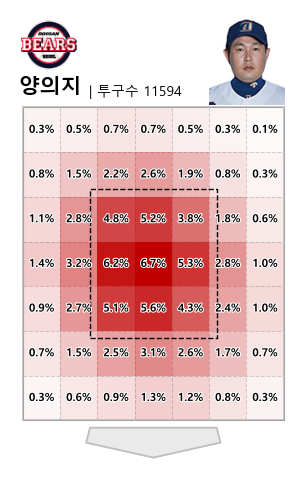

In [126]:
fig = plt.figure(figsize=(4,5), dpi = 100)
ax = plt.subplot(111) # nrows=2, ncols=1, index=1
data = data[data['zone101']!=99]
plot_df = data[data['cid'] == '양의지-76232']
max_value = plot_df['pct_pitch'].max()
team_name = plot_df['p_team'].iloc[0]
team_id = plot_df['p_emblem'].iloc[0]
team_color = plot_df['team_color'].iloc[0]
player_name = plot_df['catcher'].iloc[0]
cid = plot_df['catcher_ID'].iloc[0]
total_pitch = plot_df['total_pitch'].iloc[0]

pitch_divisions(ax, grids = True)

for zone in plot_df['zone101']:
    pitch = plot_df[plot_df['zone101'] == zone]['pct_pitch'].iloc[0]
    x_lim = [zone_areas101[zone]['x_lower_bound'], zone_areas101[zone]['x_upper_bound']]
    y1 = zone_areas101[zone]['y_lower_bound']
    y2 = zone_areas101[zone]['y_upper_bound']
    ax.fill_between(x=x_lim, y1=y1, y2=y2, color='#C00000', alpha=(pitch/max_value), zorder=0, ec='None')
    x_pos = x_lim[0] + abs(x_lim[0] - x_lim[1])/2
    y_pos = y1 + abs(y1 - y2)/2
    text_ = ax.annotate(xy=(x_pos, y_pos), text=f'{pitch:.1%}', ha='center', va='center', color='black', weight='bold', size=8)
    text_.set_path_effects([path_effects.Stroke(linewidth=1.5, foreground='white'), path_effects.Normal()])
    
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

    # -- Transformation functions
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
ax_coords = DC_to_NFC((-1.77, 4.8))
ax_size = 0.19
image_ax = fig.add_axes([ax_coords[0], ax_coords[1], ax_size, ax_size],fc='None')
logo_url = 'https://lgcxydabfbch3774324.cdn.ntruss.com/KBO_IMAGE/KBOHome/resources/images/emblem/regular/2022/'
logo_img = Image.open(urllib.request.urlopen(f"{logo_url}{team_id}.png"))
image_ax.imshow(logo_img)
image_ax.axis("off")
ax_text(x=-1.8, y=5, s=f'{player_name} <| 투구수 {total_pitch:.0f}>', highlight_textprops=[{'size':10, 'weight':'normal'}]
                    , ax=ax, weight='bold', size=15)

ax_coords2 = DC_to_NFC((0.74, 4.64))
ax_size = 0.19
image_ax = fig.add_axes([ax_coords2[0], ax_coords2[1], ax_size, ax_size],fc='None')
kbo_url = 'https://lgcxydabfbch3774324.cdn.ntruss.com/KBO_IMAGE/person/middle/2022/'
player_img = Image.open(urllib.request.urlopen(f'{kbo_url}{cid:.0f}.jpg'))
image_ax.imshow(player_img)
image_ax.axis("off")


In [127]:
data.groupby(['p_team', 'p_emblem', 'yy', 'cid'])[['cid']].nunique().unstack()

cid                                          \
cid                  강민호-74540 강태율-65514 권혁경-51640 김기연-66112 김민식-62864   
p_team p_emblem yy                                                       
DS     OB       2022       NaN       NaN       NaN       NaN       NaN   
HH     HH       2022       NaN       NaN       NaN       NaN       NaN   
KIA    HT       2022       NaN       NaN       1.0       NaN       NaN   
KT     KT       2022       NaN       NaN       NaN       NaN       NaN   
KW     WO       2022       NaN       NaN       NaN       NaN       NaN   
LG     LG       2022       NaN       NaN       NaN       1.0       NaN   
LT     LT       2022       NaN       1.0       NaN       NaN       NaN   
NC     NC       2022       NaN       NaN       NaN       NaN       NaN   
SS     SS       2022       1.0       NaN       NaN       NaN       NaN   
SSG    SK       2022       NaN       NaN       NaN       NaN       1.0   

                                                                        ...  \
cid                  김민혁-65269 김선우-51604 김시앙-51303 김응민-60288 김재성-65132  ...   
p_team p_emblem yy                                                      ...   
DS     OB       2022       1.0       NaN       NaN       NaN       NaN  ...   
HH     HH       2022       NaN       NaN       NaN       NaN       NaN  ...   
KIA    HT       2022       NaN       1.0       NaN       NaN       NaN  ...   
KT     KT       2022       NaN       NaN       NaN       NaN       NaN  ...   
KW     WO       2022       NaN       NaN       1.0       NaN       NaN  ...   
LG     LG       2022       NaN       NaN       NaN       NaN       NaN  ...   
LT     LT       2022       NaN       NaN       NaN       NaN       NaN  ...   
NC     NC       2022       NaN       NaN       NaN       1.0       NaN  ...   
SS     SS       2022       NaN       NaN       NaN       NaN       1.0  ...   
SSG    SK       2022       NaN       NaN       NaN       NaN       NaN  ...   

                                                                        \
cid                  정보근-68518 조대현-68089 조형우-51865 지시완-64717 최용제-64213   
p_team p_emblem yy                                                       
DS     OB       2022       NaN       NaN       NaN       NaN       1.0   
HH     HH       2022       NaN       NaN       NaN       NaN       NaN   
KIA    HT       2022       NaN       NaN       NaN       NaN       NaN   
KT     KT       2022       NaN       1.0       NaN       NaN       NaN   
KW     WO       2022       NaN       NaN       NaN       NaN       NaN   
LG     LG       2022       NaN       NaN       NaN       NaN       NaN   
LT     LT       2022       1.0       NaN       NaN       1.0       NaN   
NC     NC       2022       NaN       NaN       NaN       NaN       NaN   
SS     SS       2022       NaN       NaN       NaN       NaN       NaN   
SSG    SK       2022       NaN       NaN       1.0       NaN       NaN   

                                                                        
cid                  최재훈-78288 한승택-63722 허관회-69706 허도환-77243 허인서-52764  
p_team p_emblem yy                                                      
DS     OB       2022       NaN       NaN       NaN       NaN       NaN  
HH     HH       2022       1.0       NaN       1.0       NaN       1.0  
KIA    HT       2022       NaN       1.0       NaN       NaN       NaN  
KT     KT       2022       NaN       NaN       NaN       NaN       NaN  
KW     WO       2022       NaN       NaN       NaN       NaN       NaN  
LG     LG       2022       NaN       NaN       NaN       1.0       NaN  
LT     LT       2022       NaN       NaN       NaN       NaN       NaN  
NC     NC       2022       NaN       NaN       NaN       NaN       NaN  
SS     SS       2022       NaN       NaN       NaN       NaN       NaN  
SSG    SK       2022       NaN       NaN       NaN       NaN       NaN  

[10 rows x 46 columns]

In [128]:
order_team.groupby(['yy', 'p_team', 'order_num'])[['cid']].count().unstack().reset_index()

yy p_team  cid                                             
order_num                 1    2    3    4    5    6    7    8    9   10
0          2022     DS  NaN  NaN  6.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN
1          2022     HH  NaN  NaN  NaN  NaN  NaN  NaN  7.0  NaN  NaN  NaN
2          2022    KIA  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN
3          2022     KT  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN  NaN
4          2022     KW  NaN  NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN
5          2022     LG  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0
6          2022     LT  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.0  NaN
7          2022     NC  5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
8          2022     SS  NaN  NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN
9          2022    SSG  NaN  5.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

<AxesSubplot: xlabel='total_pitch', ylabel='Density'>

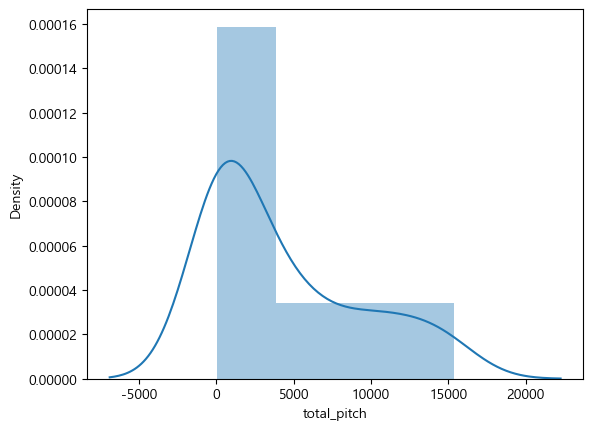

In [129]:
sns.distplot(order_team['total_pitch'])

---
---
### 1) Zone101 Plot (투수:전체 × 타자:전체)

In [130]:
# data.to_csv(YJPATH3+ OUTDIR3+'zone101-hand-2023-02-17.csv', encoding='cp949', index=False)

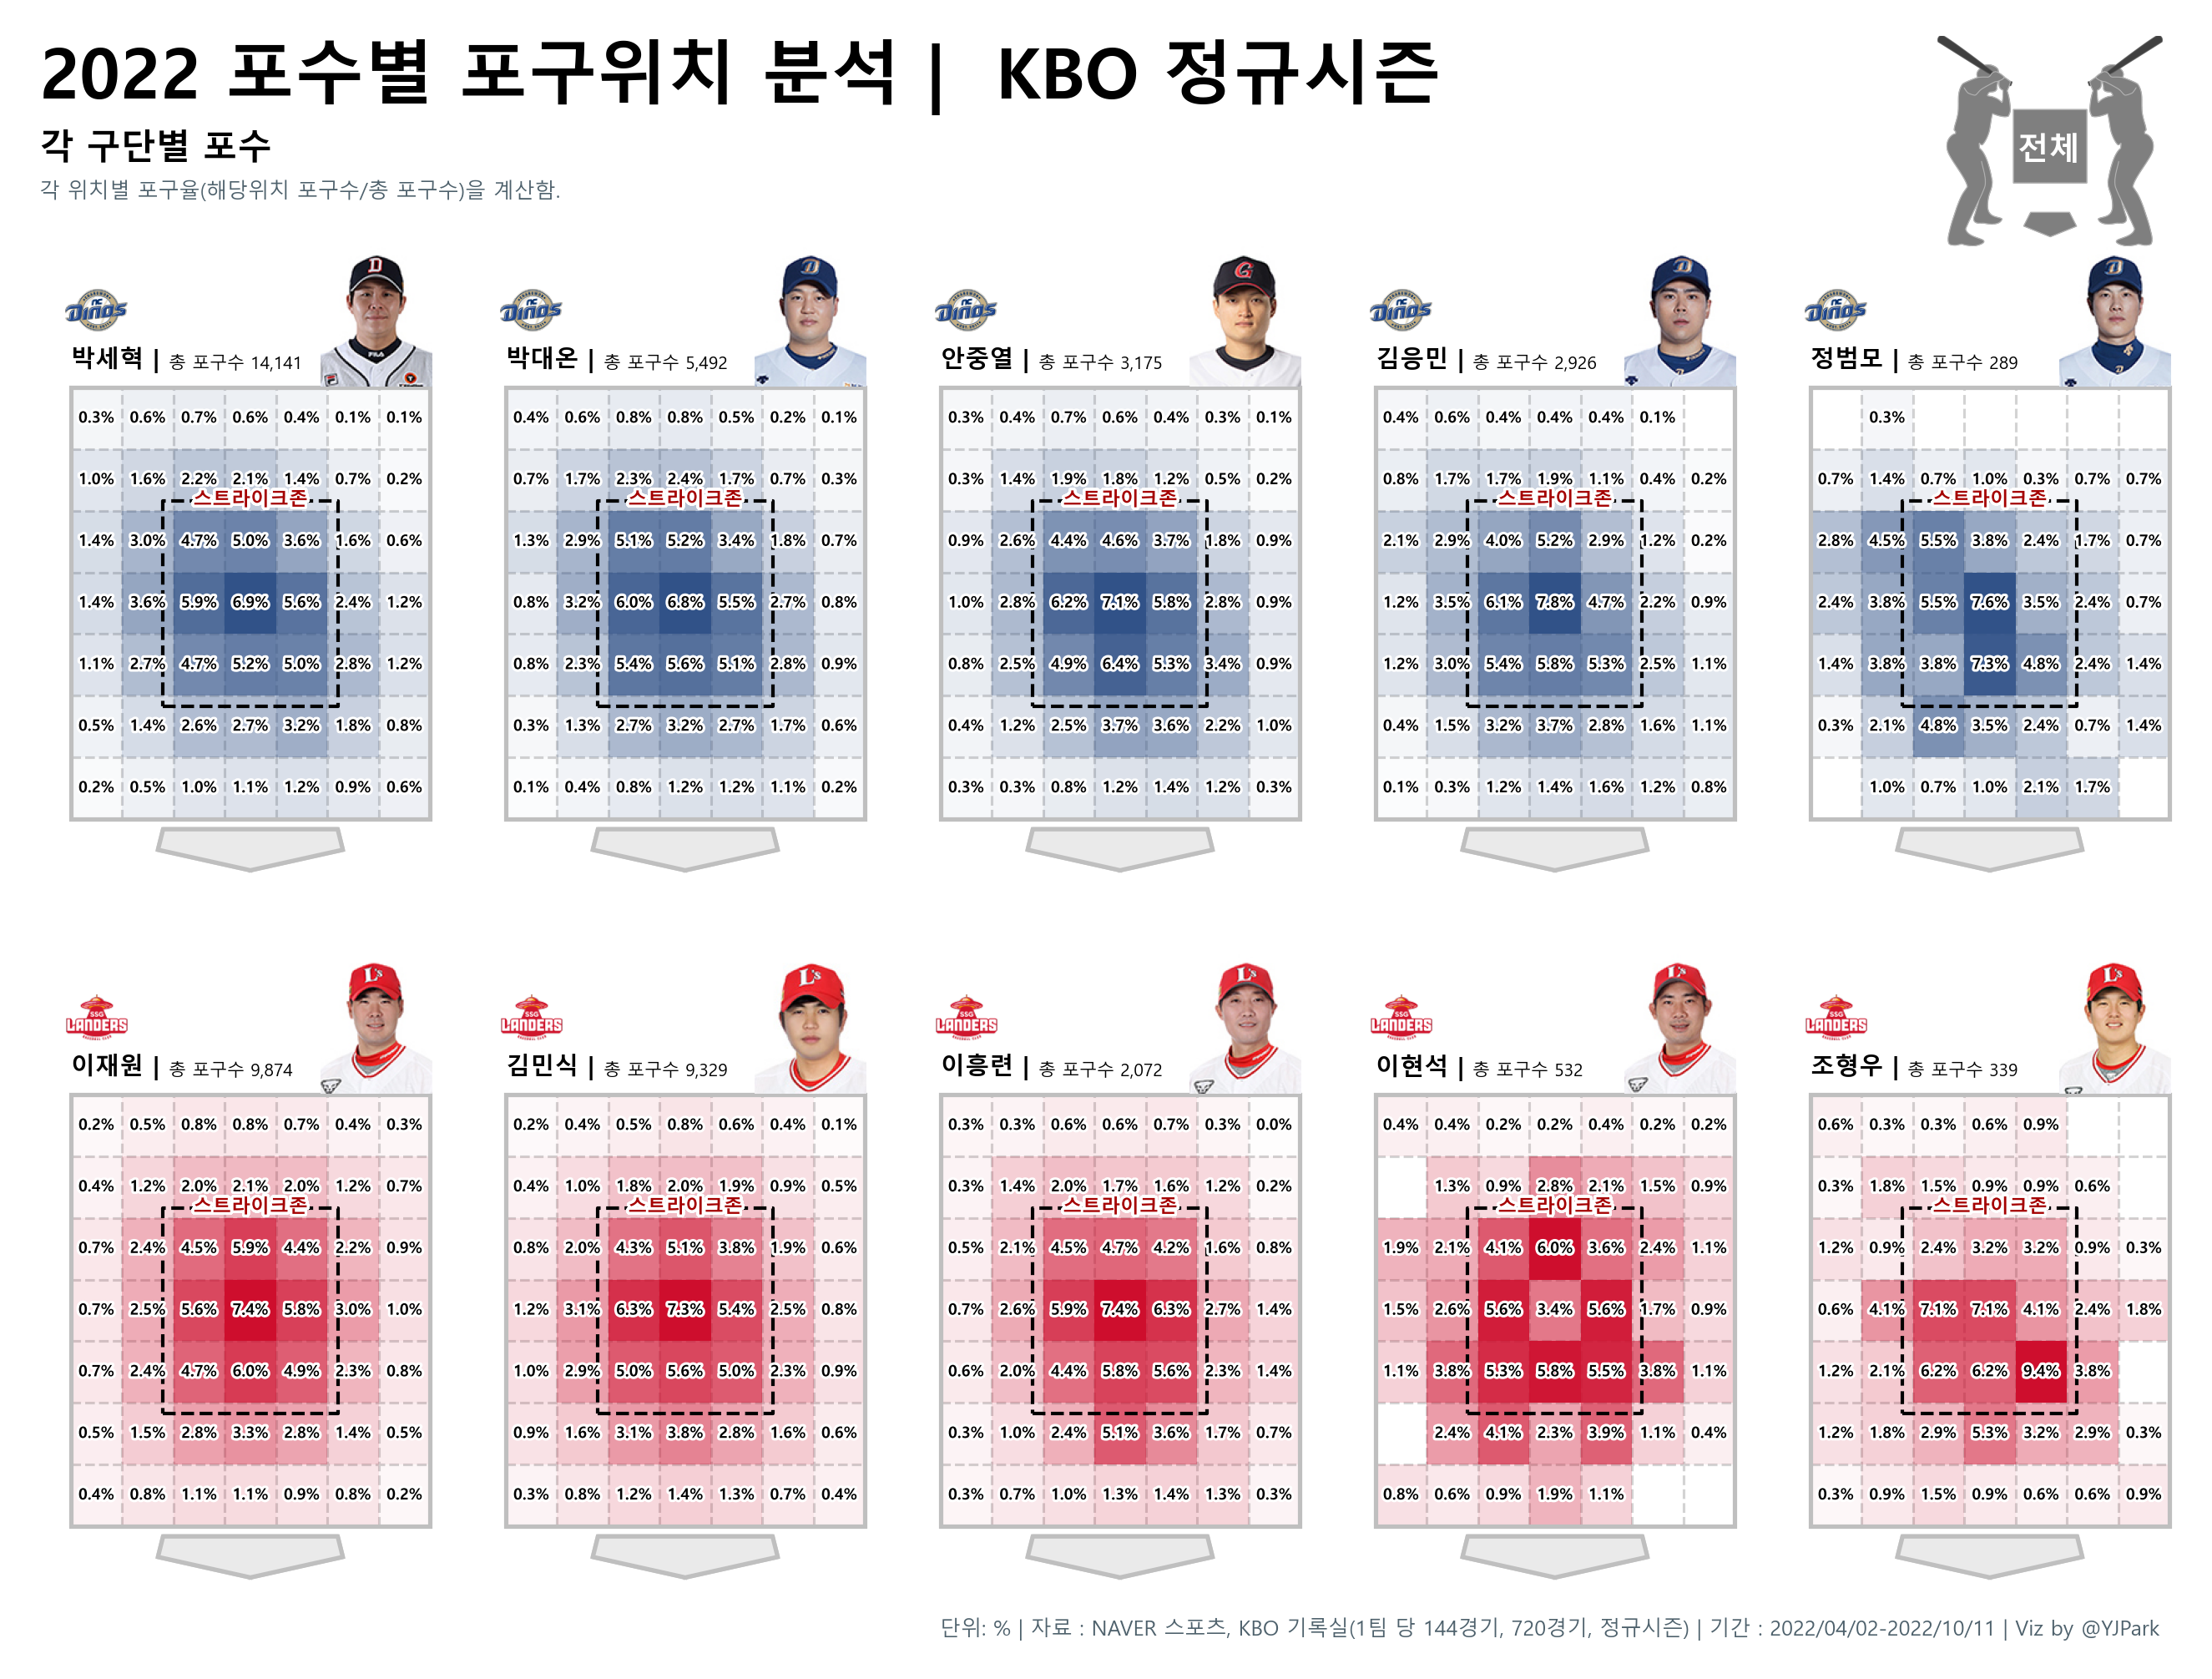

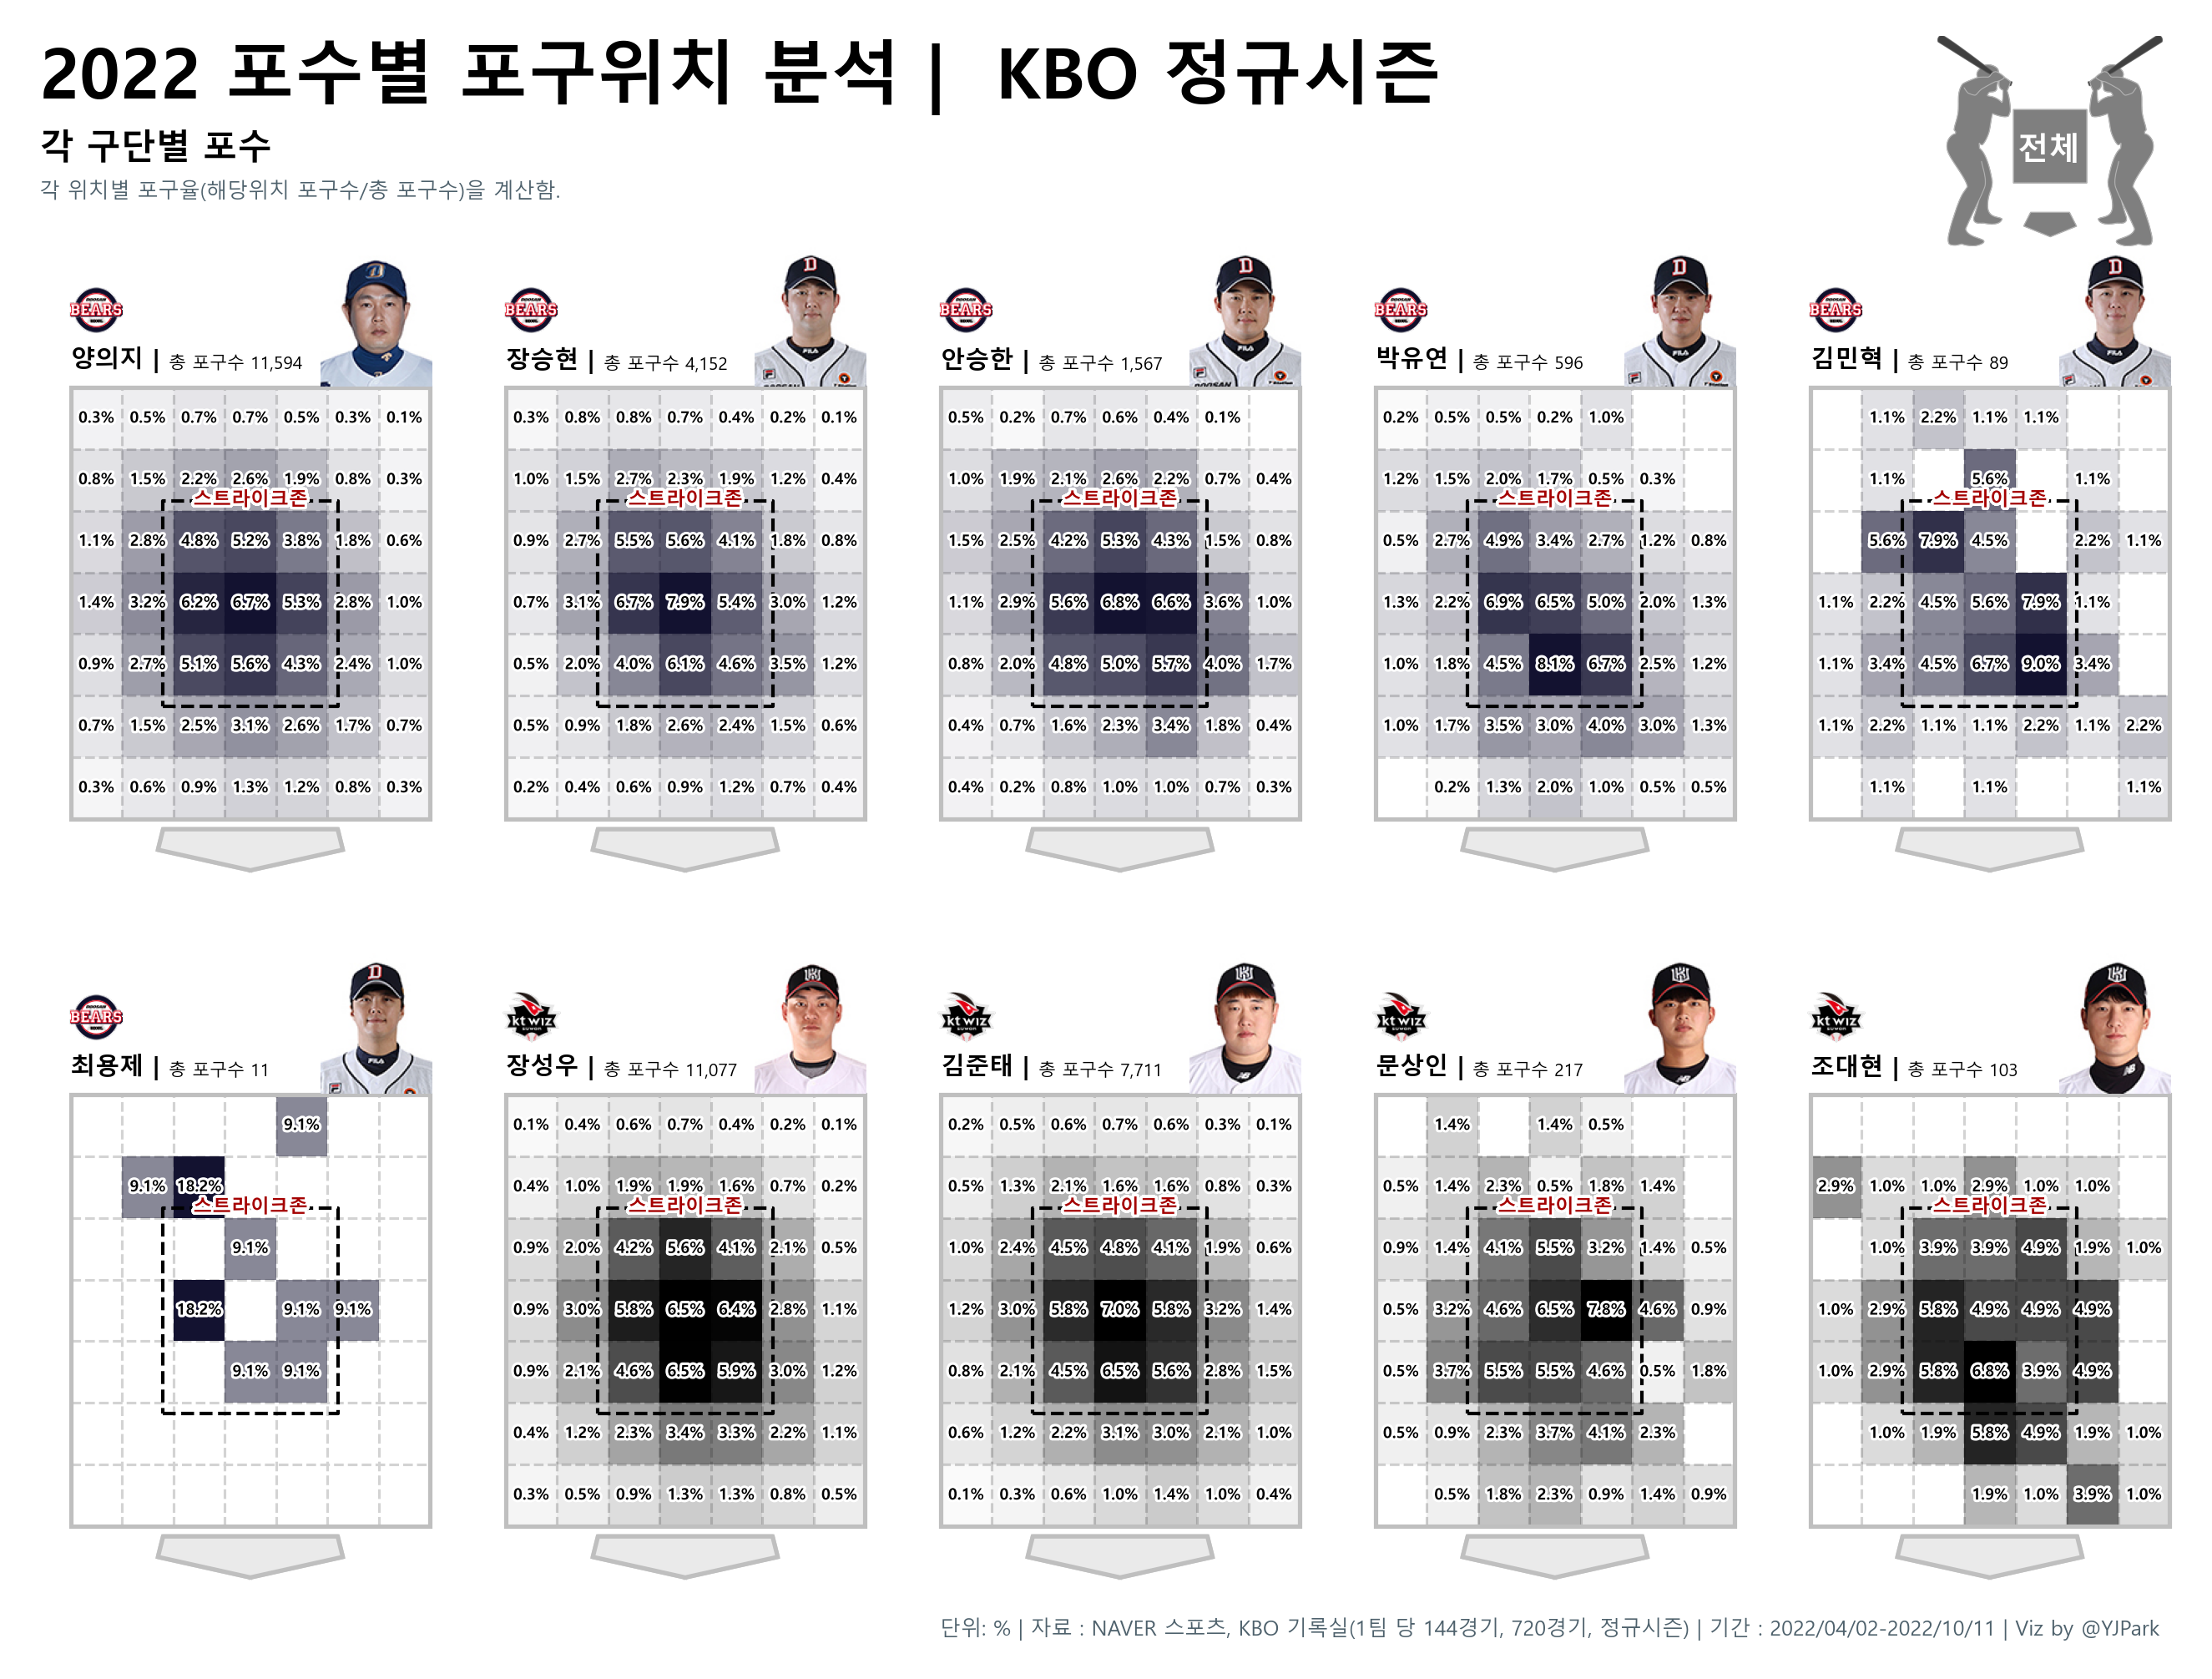

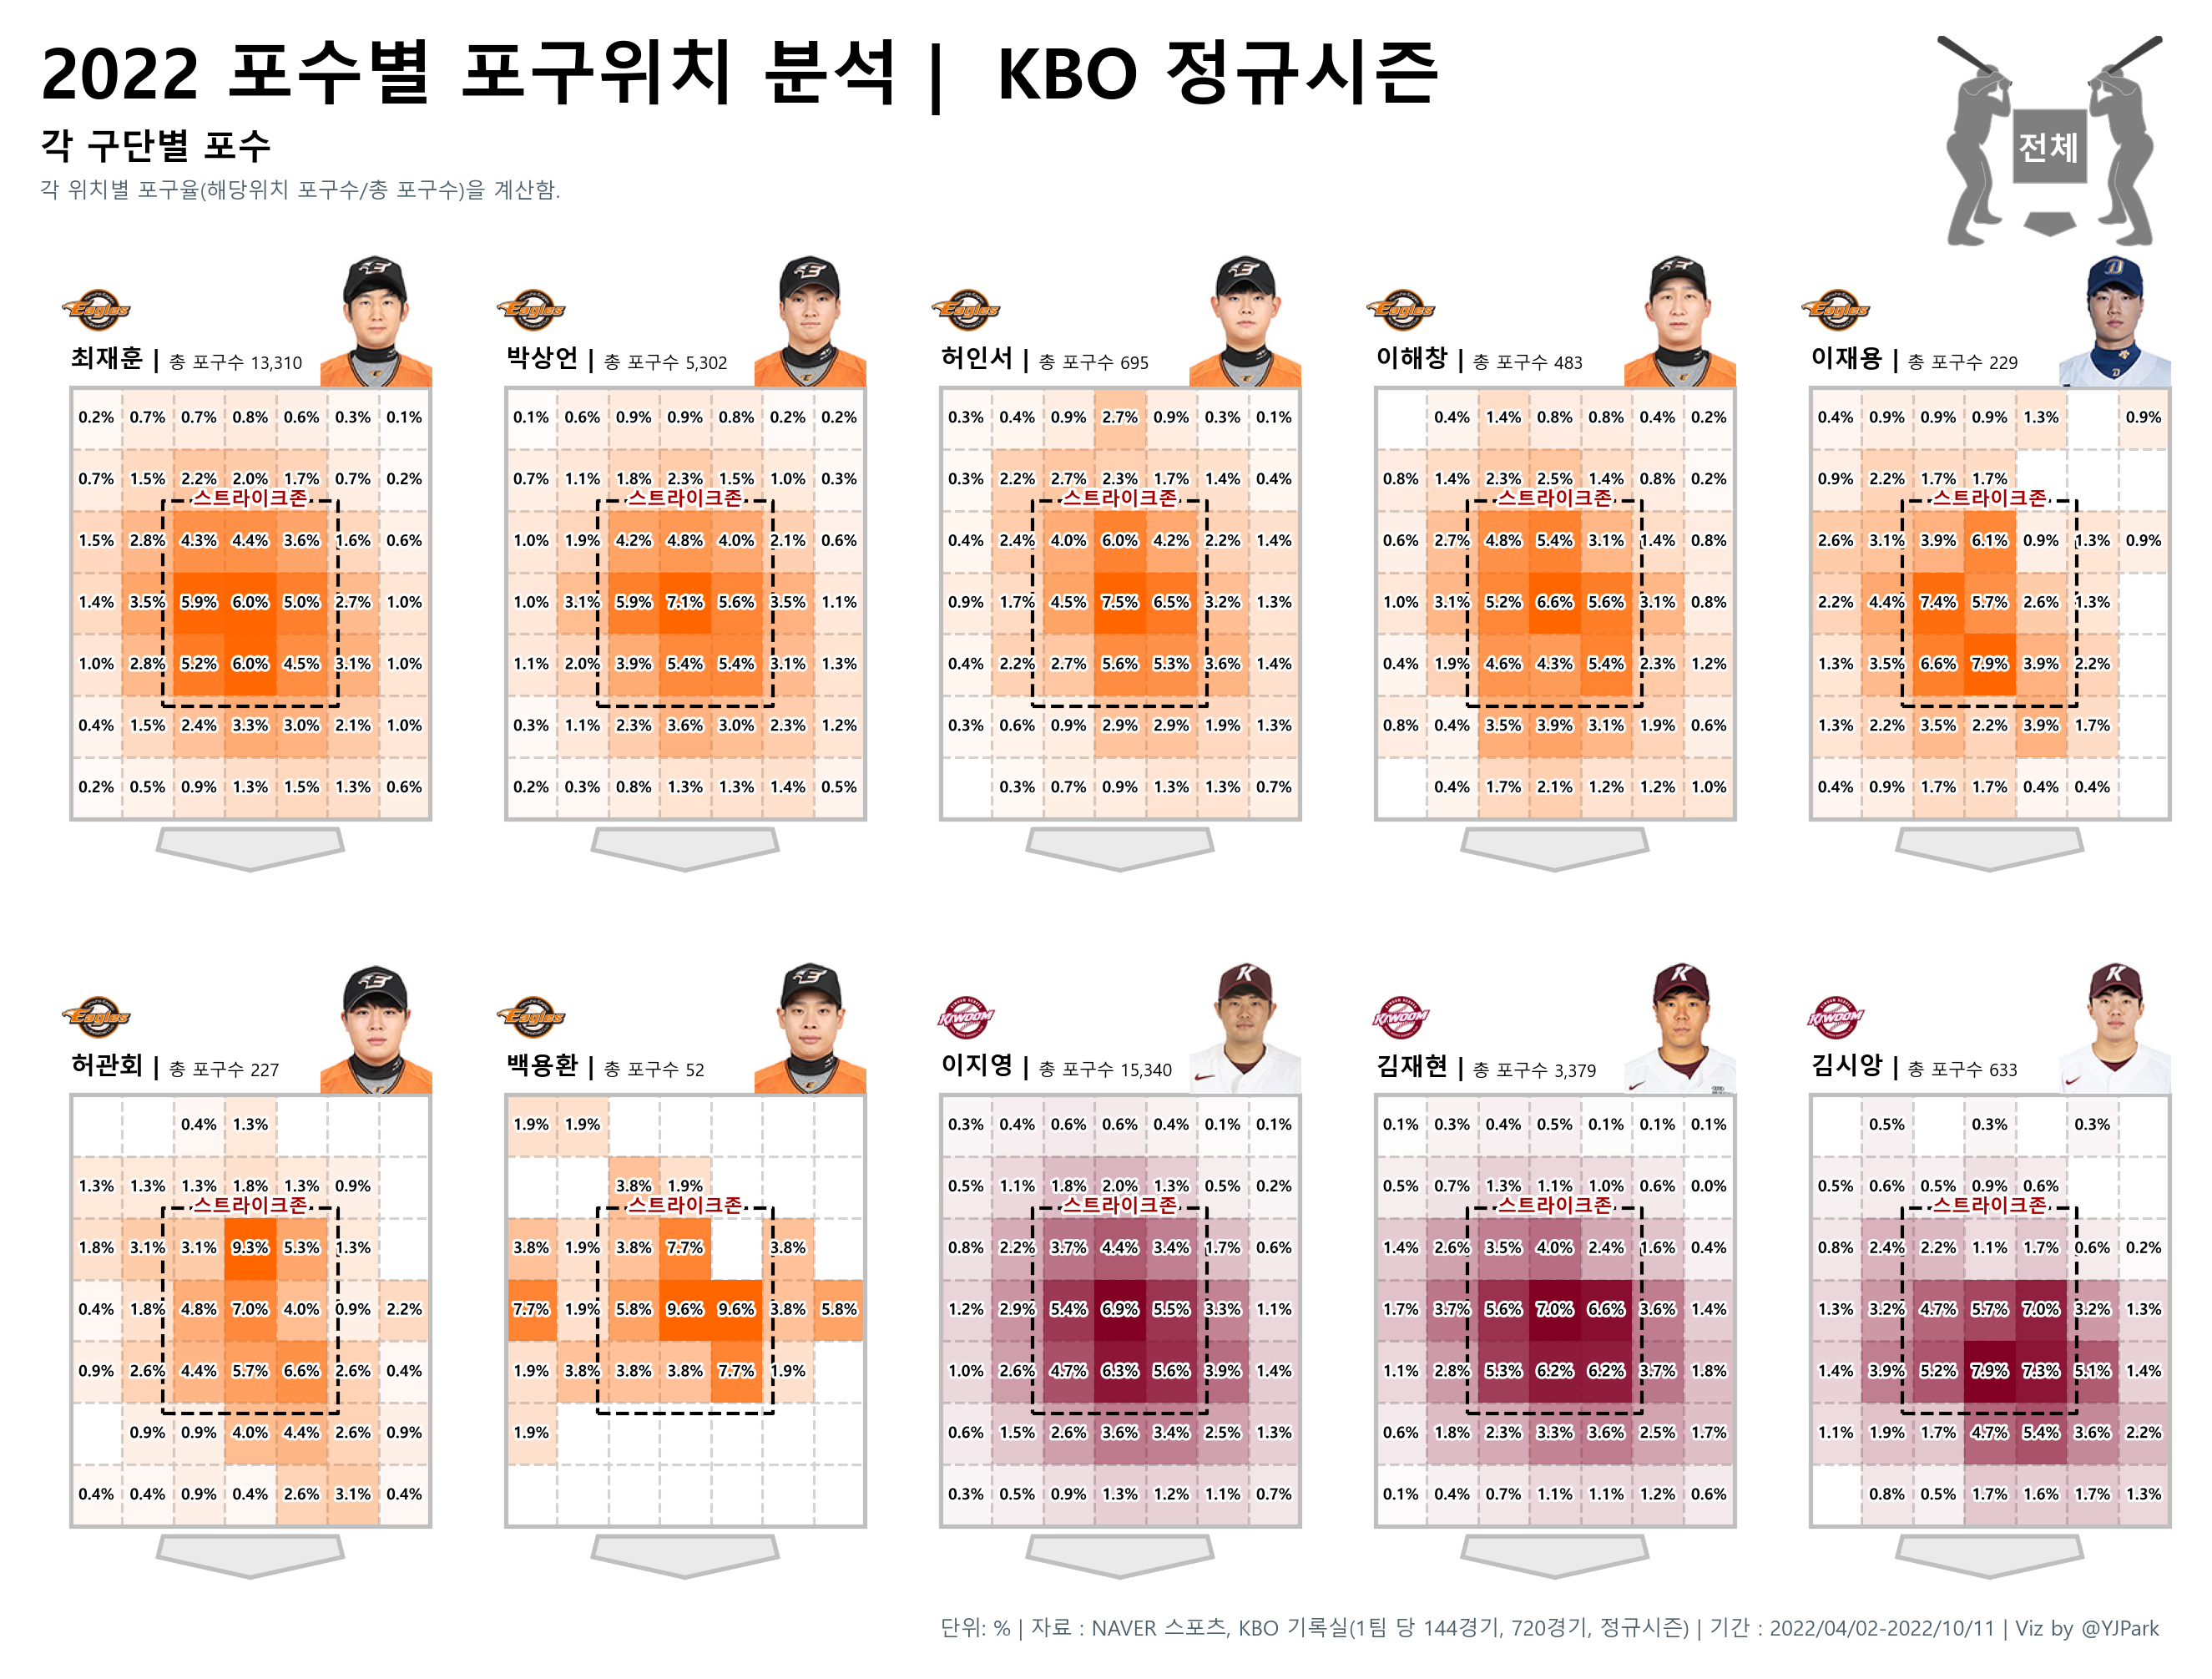

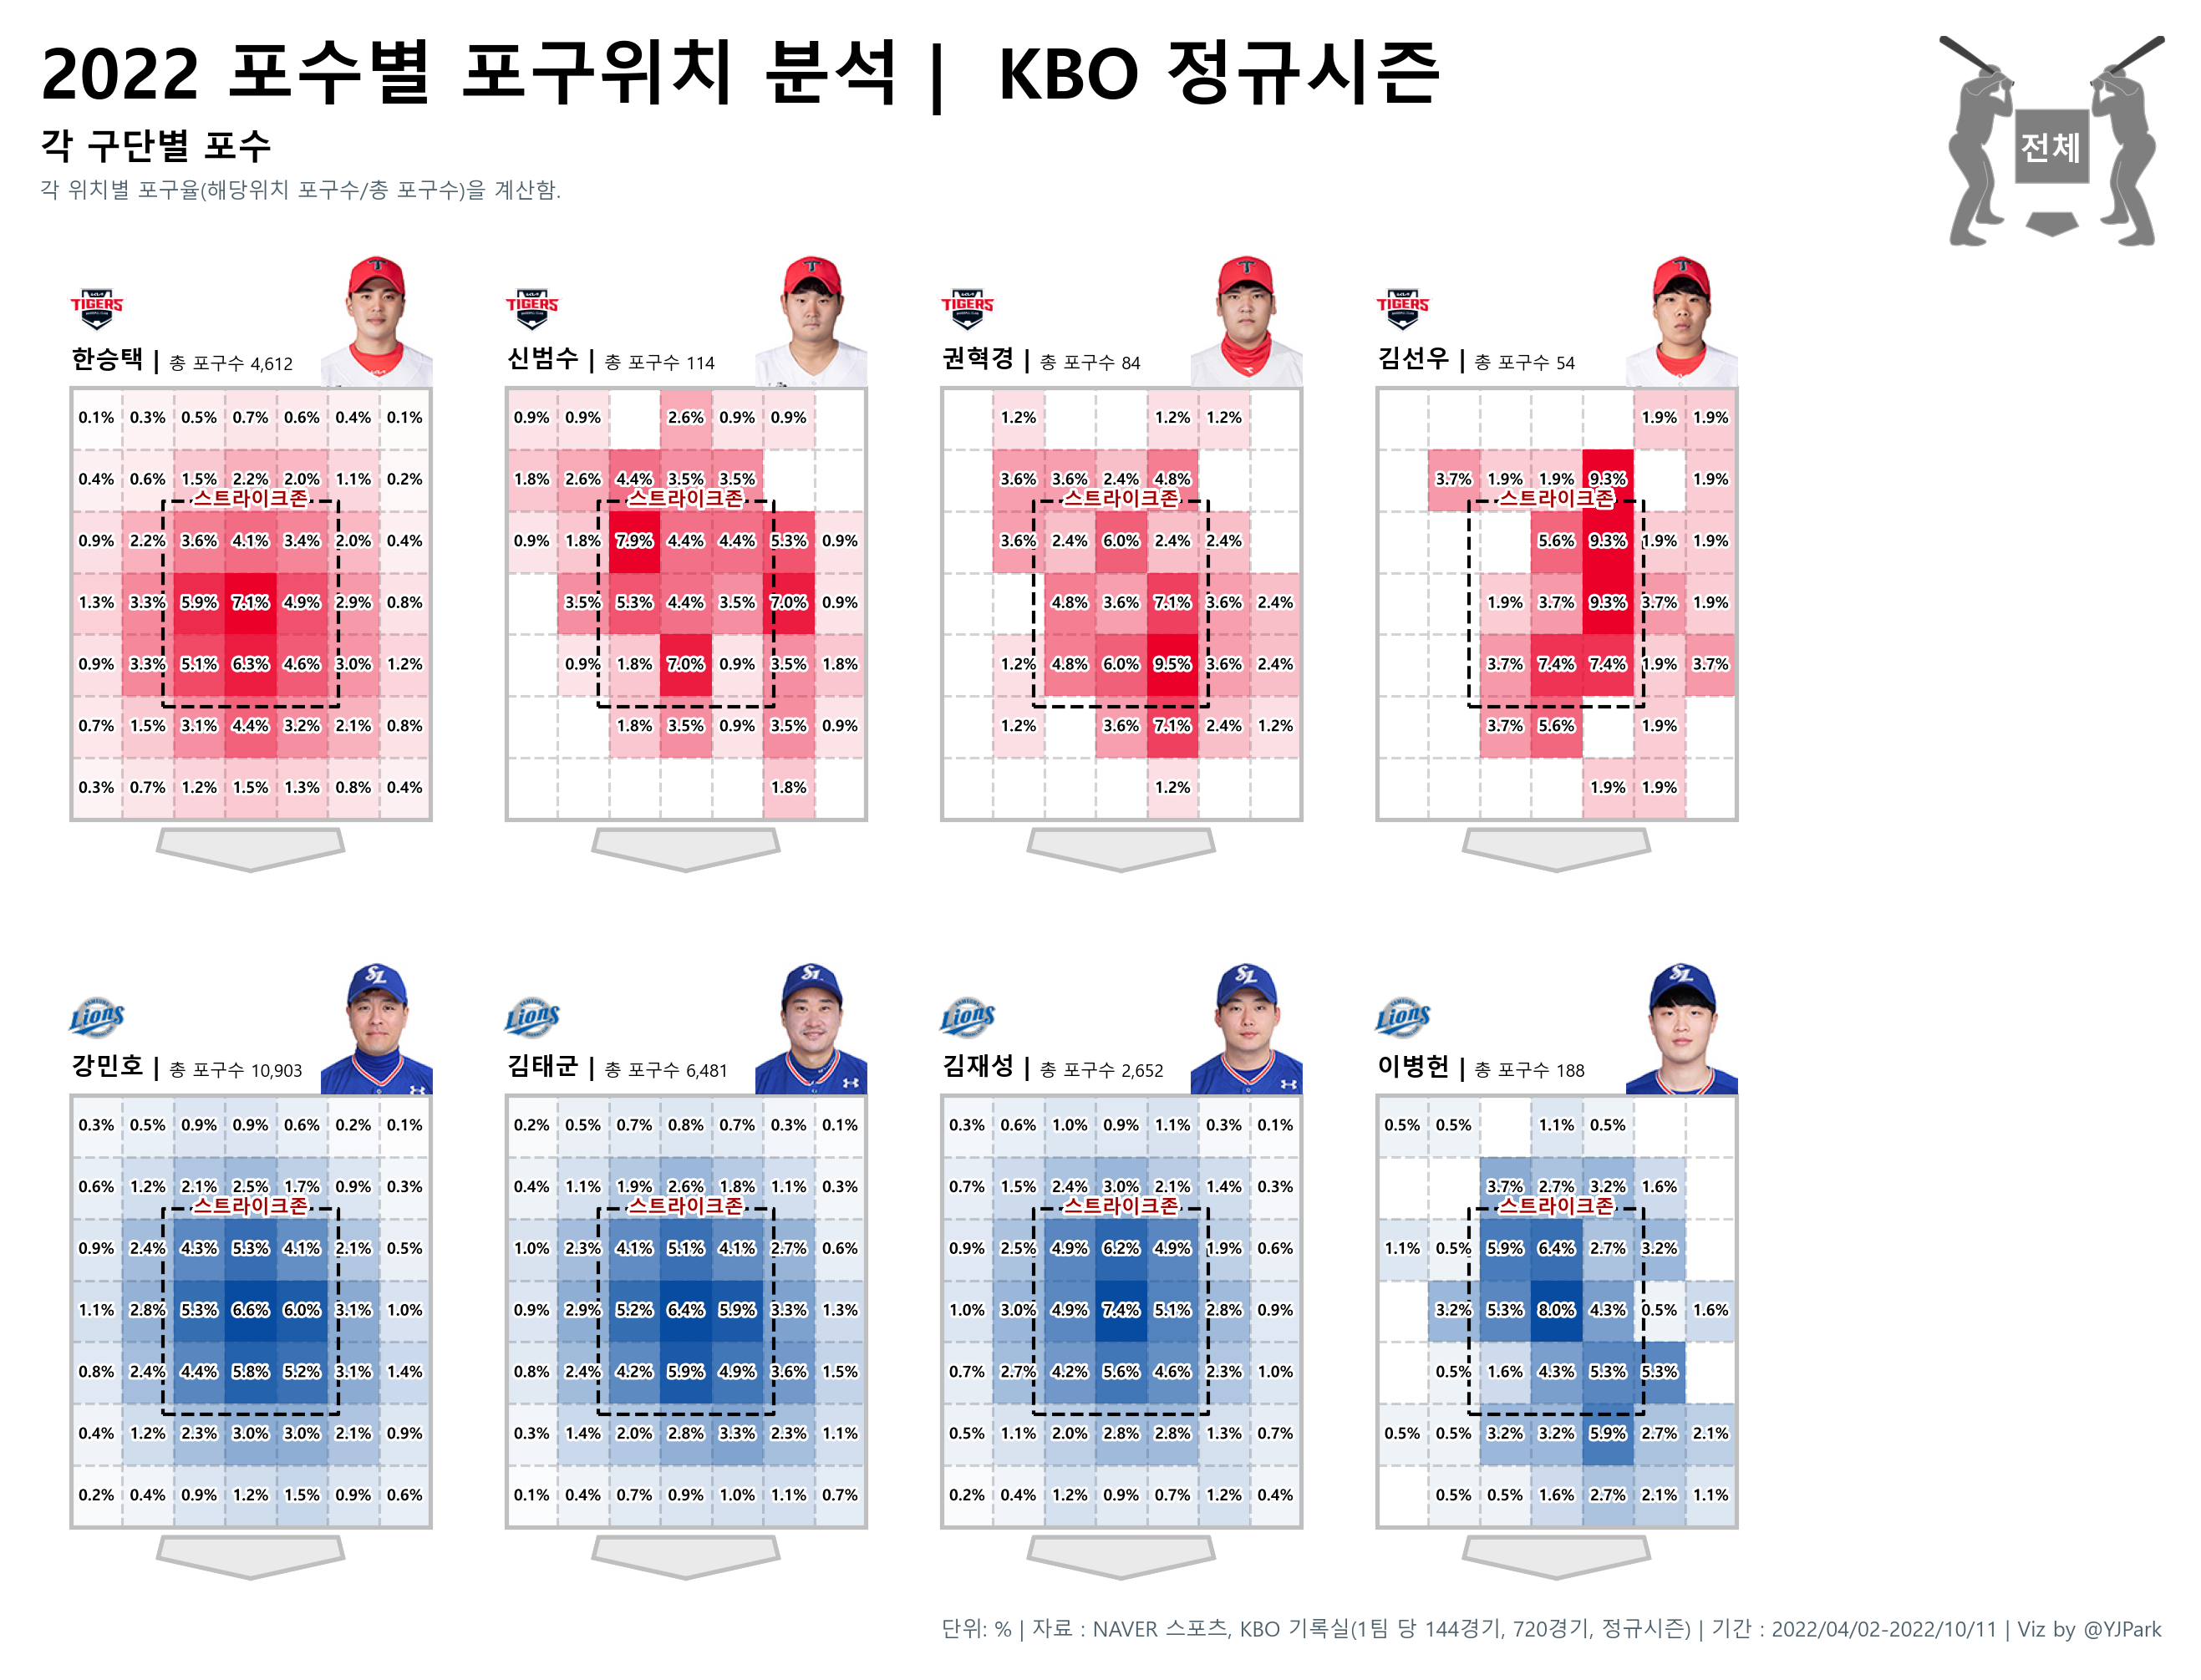

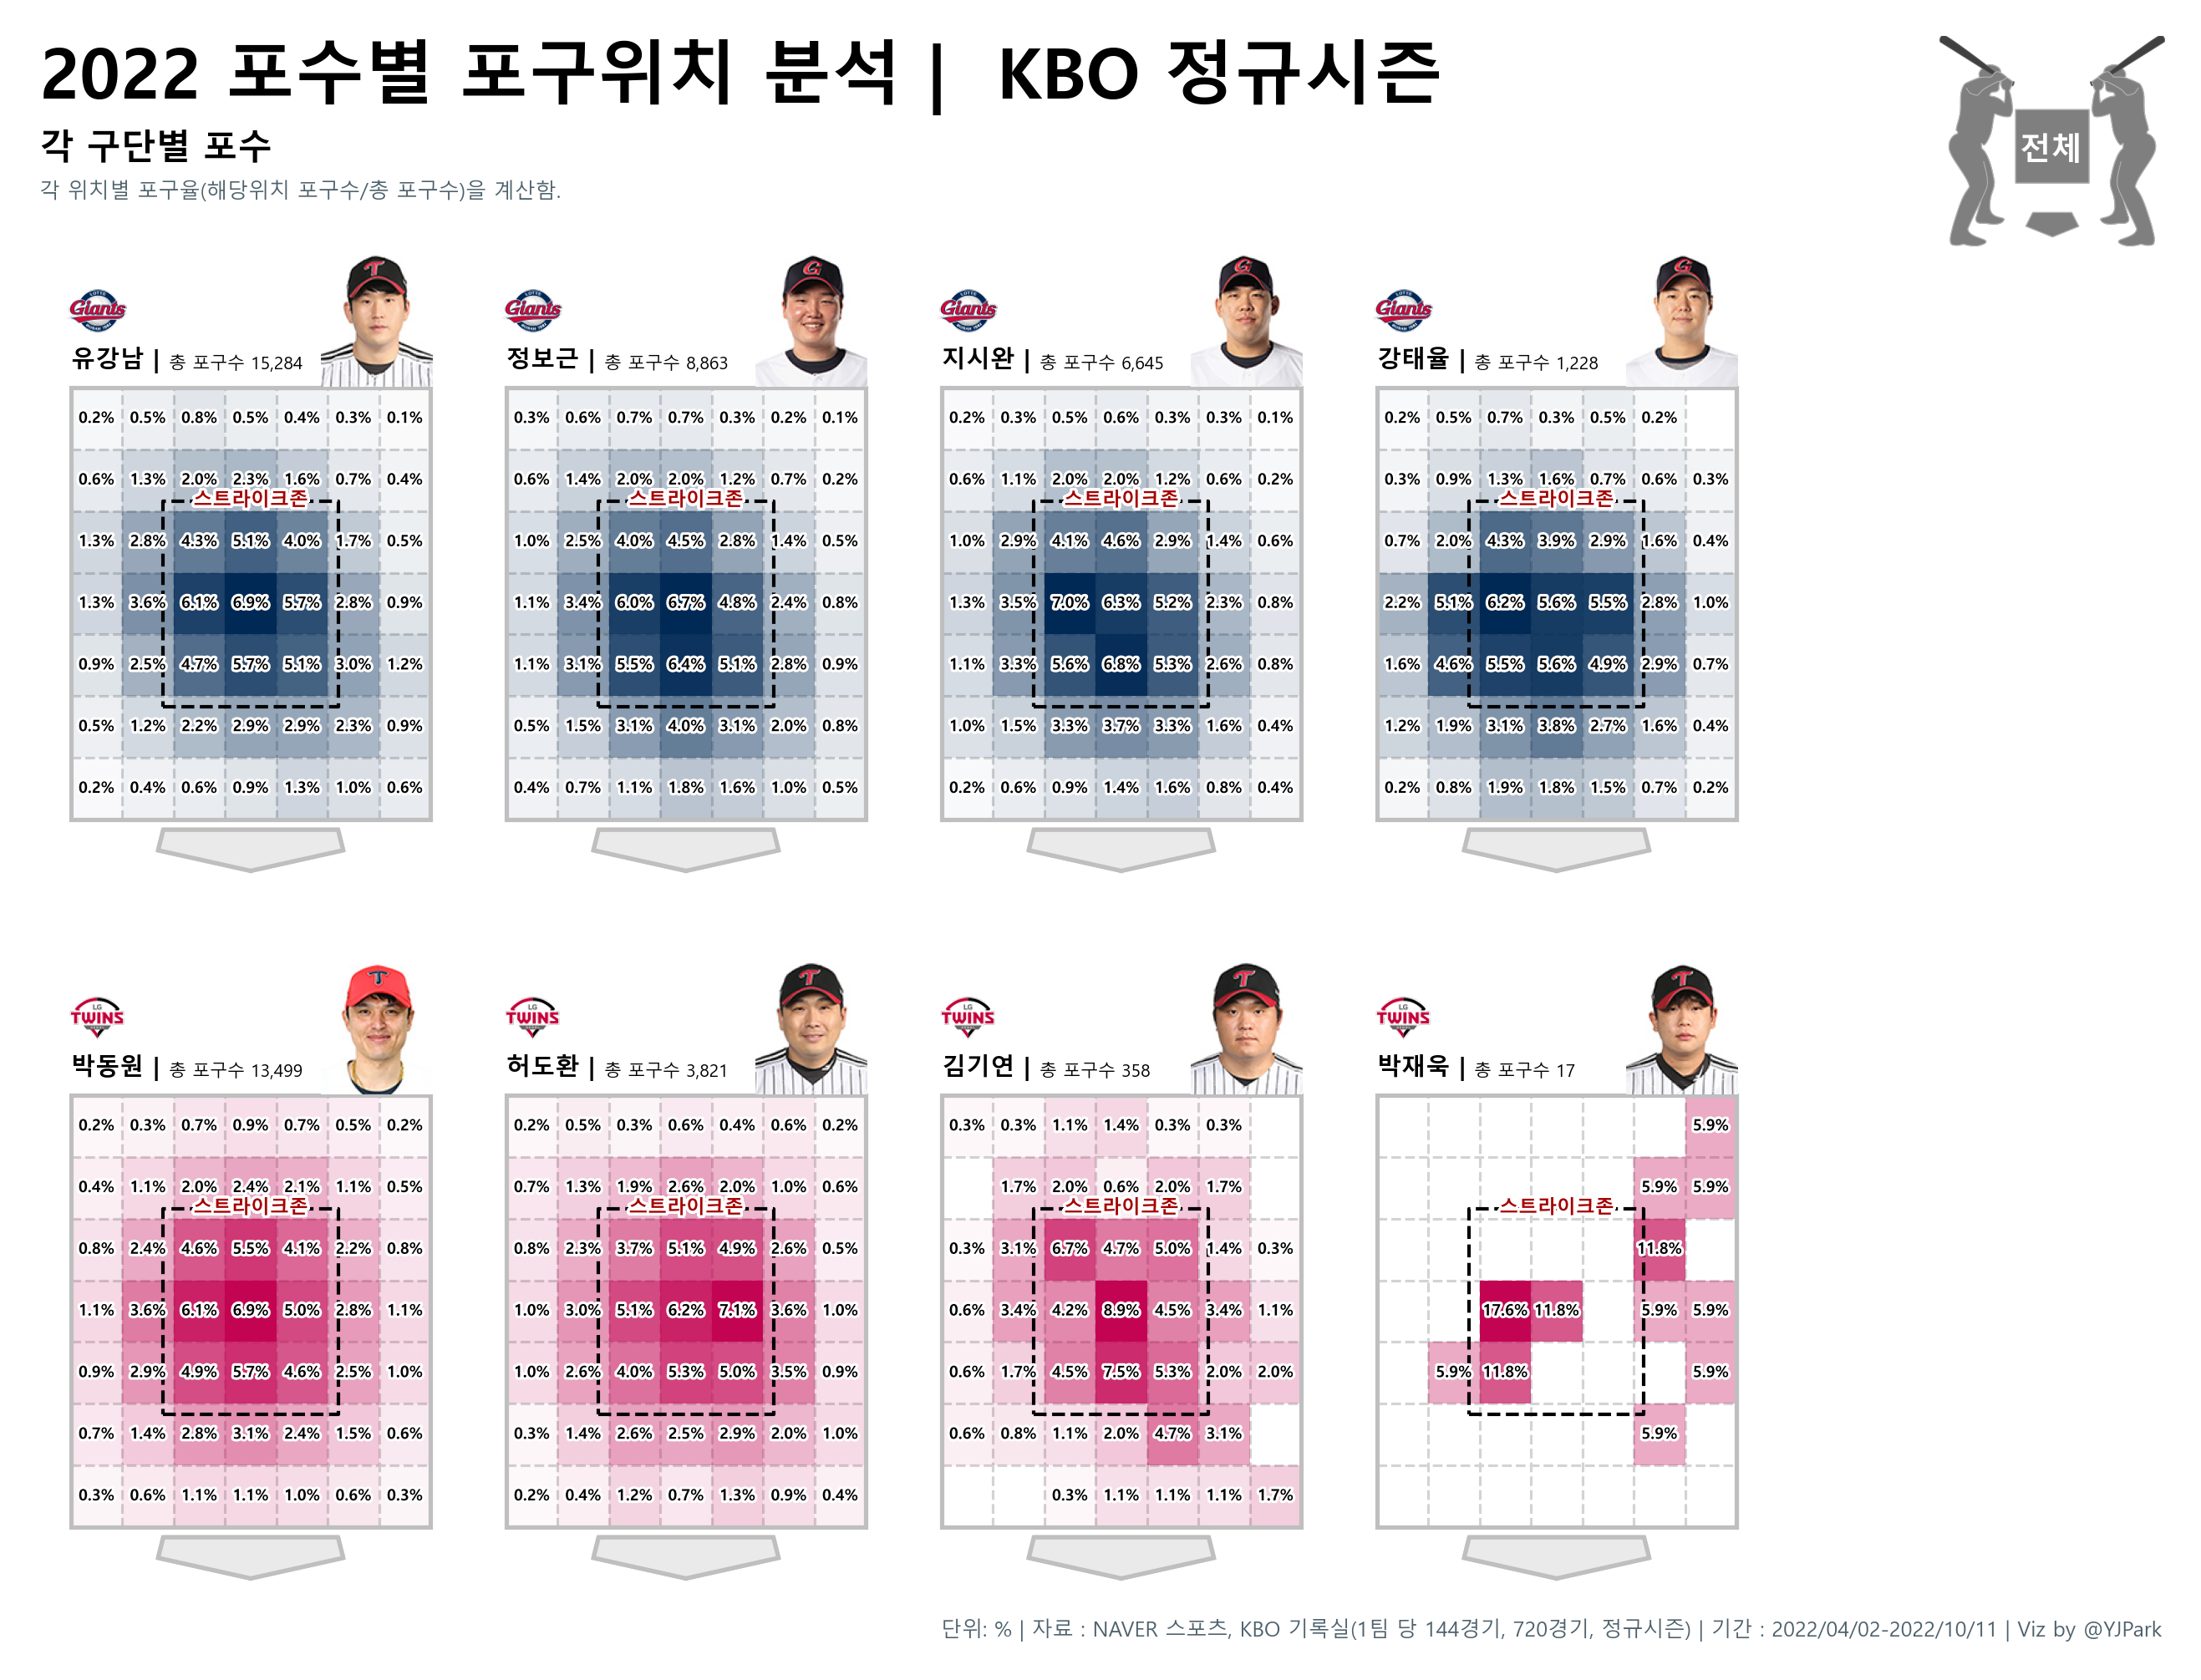

In [131]:
odf_list = ['order_team10', 'order_team20', 'order_team40']
year_list = ['2022']*3
for d, y in zip(odf_list, year_list):
    var = f'{d}'
    layout = [[1,2,3,4,5], [6,7,8,9,10]]
    height_ratios = [1]*2 # 길이 × 행 개수 # width_ratios = [1]*4 # 길이 × 열 개수
    fig = plt.figure(figsize=(11,7), dpi=300)
    axs = fig.subplot_mosaic(layout, gridspec_kw={'wspace':.1, 'hspace':.1})

    fig_text(x = .12, y = .99, s = "{} 포수별 포구위치 분석 |  KBO 정규시즌".format(y), va = "bottom", ha = "left", fontsize = 20, color = "black", weight = "bold")
    fig_text(x = .12, y = .96, s = "각 구단별 포수", va = "bottom", ha = "left", fontsize = 10, color = "black", weight = "bold")
    fig_text(x = .12, y = .94, s = "각 위치별 포구율(해당위치 포구수/총 포구수)을 계산함.", va = "bottom", ha = "left", fontsize = 6, color = "#4E616C")
    fig_text(x = .89, y = .12, s = "단위: % | 자료 : NAVER 스포츠, KBO 기록실(1팀 당 144경기, 720경기, 정규시즌) | 기간 : 2022/04/02-2022/10/11 | Viz by @YJPark", va = "bottom", ha = "right", fontsize = 6, color = "#4E616C")

    counter = 0
    for k, ax in axs.items():
            cid = globals()[var]['cid'].iloc[counter]
            plot_zone_location(ax, fig, cid=cid, data=data)
            counter += 1

    ax2 = fig.add_axes([.79, .915, .12, .12])
    condition_icon = Image.open("F:/YJ-format-230125/data/img/전체_전체2.png")
    ax2.imshow(condition_icon)
    ax2.axis('off')
    fig_text(x = .861, y = .96, s = "전체", va = "bottom", ha = "right", fontsize = 9, color = "w", weight = "bold")
    
odf_list2 = ['order_team30', 'order_team50']
layout3 = [[1,2,3,4,"."], [6,7,8,9,"."]]
for d, y in zip(odf_list2, year_list):
    var = f'{d}'
    if var == 'order_team30':
        layout = layout3      
    if var == 'order_team50':
        layout = layout3
    else: pass
    layout = layout
    height_ratios = [1]*2 # 길이 × 행 개수 # width_ratios = [1]*4 # 길이 × 열 개수
    fig = plt.figure(figsize=(11,7), dpi=300)
    axs = fig.subplot_mosaic(layout, gridspec_kw={'wspace':.1, 'hspace':.1})
    fig_text(x = .12, y = .99, s = "{} 포수별 포구위치 분석 |  KBO 정규시즌".format(y), va = "bottom", ha = "left", fontsize = 20, color = "black", weight = "bold")
    fig_text(x = .12, y = .96, s = "각 구단별 포수", va = "bottom", ha = "left", fontsize = 10, color = "black", weight = "bold")
    fig_text(x = .12, y = .94, s = "각 위치별 포구율(해당위치 포구수/총 포구수)을 계산함.", va = "bottom", ha = "left", fontsize = 6, color = "#4E616C")
    fig_text(x = .89, y = .12, s = "단위: % | 자료 : NAVER 스포츠, KBO 기록실(1팀 당 144경기, 720경기, 정규시즌) | 기간 : 2022/04/02-2022/10/11 | Viz by @YJPark", va = "bottom", ha = "right", fontsize = 6, color = "#4E616C")

    counter = 0
    for k, ax in axs.items():
           cid = globals()[var]['cid'].iloc[counter]
           plot_zone_location(ax, fig, cid=cid, data=data)
           counter += 1

    ax2 = fig.add_axes([.79, .915, .12, .12])
    condition_icon = Image.open("F:/YJ-format-230125/data/img/전체_전체2.png")
    ax2.imshow(condition_icon)
    ax2.axis('off')
    fig_text(x = .861, y = .96, s = "전체", va = "bottom", ha = "right", fontsize = 9, color = "w", weight = "bold")

---
# 4️⃣ Visulization Data QC
- 데이터 검토하기

### 0) 집계

- 홈플레이트 = 43cm (16.9291inch | 1.411ft)
- 공인구 둘레 = 233.5mm (2r=74.36mm(r=37.18mm)| 0.293inch(0.1465inch)| 0.243ft(0.122ft) | 둘레공식 = 2rπ) 
- Strike Zone = 1.654ft

<img src="http://blogs.fangraphs.com/wp-content/uploads/2021/05/Attack-Zones.png" height="300">
<img src="https://pbs.twimg.com/media/Ds0CyCUVYAIGI3s.jpg" height="300">
<img src="https://img.seoul.co.kr//img/upload/2019/02/13/SSI_20190213184237_V.jpg" height="300">
<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FnHAui%2Fbtq4c2NSLUa%2FBw28pVwwoHKUcoULao7mOK%2Fimg.png" height="200">

---
### 0) 데이터확인

In [132]:
df = pd.read_csv(YJPATH + OUTDIR + r'pbp-interim-2023-02-18.csv', encoding='cp949', low_memory=False)
test = df.copy()
test['px_qcut'] = pd.cut(test['px'], np.arange(-8.25, 8.75, .5))
test['pz_qcut'] = pd.cut(test['pz'], np.arange(-4.4, 8.8, .6))
# psh22 = test.query("yy==2022 and catcher=='박세혁'").groupby(['pz_qcut', 'px_qcut'])[['pitch_type']].count().unstack().reset_index().droplevel(axis=1,level=0)
# psh22.to_excel(YJPATH3+OUTDIR3+'zone-qc.xlsx', encoding="utf8")

In [133]:
test['px_qcut'].value_counts().sort_index()

(-8.25, -7.75]         0
(-7.75, -7.25]         1
(-7.25, -6.75]         3
(-6.75, -6.25]         5
(-6.25, -5.75]         6
(-5.75, -5.25]        16
(-5.25, -4.75]        46
(-4.75, -4.25]        75
(-4.25, -3.75]       182
(-3.75, -3.25]       443
(-3.25, -2.75]      1434
(-2.75, -2.25]      5675
(-2.25, -1.75]     21227
(-1.75, -1.25]     64702
(-1.25, -0.75]    148860
(-0.75, -0.25]    243182
(-0.25, 0.25]     288332
(0.25, 0.75]      252195
(0.75, 1.25]      157342
(1.25, 1.75]       69287
(1.75, 2.25]       22645
(2.25, 2.75]        6129
(2.75, 3.25]        1514
(3.25, 3.75]         495
(3.75, 4.25]         166
(4.25, 4.75]          70
(4.75, 5.25]          22
(5.25, 5.75]           6
(5.75, 6.25]           3
(6.25, 6.75]           3
(6.75, 7.25]           2
(7.25, 7.75]           2
(7.75, 8.25]           0
Name: px_qcut, dtype: int64

In [134]:
test['pz_qcut'].value_counts().sort_index()

(-4.4, -3.8]         0
(-3.8, -3.2]         3
(-3.2, -2.6]        14
(-2.6, -2.0]        95
(-2.0, -1.4]       363
(-1.4, -0.8]      1596
(-0.8, -0.2]      6596
(-0.2, 0.4]      23283
(0.4, 1.0]       69371
(1.0, 1.6]      167860
(1.6, 2.2]      291929
(2.2, 2.8]      328250
(2.8, 3.4]      233431
(3.4, 4.0]      108374
(4.0, 4.6]       37894
(4.6, 5.2]       11059
(5.2, 5.8]        2912
(5.8, 6.4]         764
(6.4, 7.0]         195
(7.0, 7.6]          63
(7.6, 8.2]          18
(8.2, 8.8]           0
Name: pz_qcut, dtype: int64

In [135]:
rowtotal = df.groupby(['zone101_new', 'yy'])[['pitch_type']].count().unstack().reset_index().droplevel(axis=1, level=0)
rowtotal.loc[:,'Row_Total'] = rowtotal.sum(numeric_only=True, axis=1)
rowtotal.rename(columns={'':'zone'}, inplace=True)
rowtotal['2017'] = round(rowtotal[2017]/rowtotal['Row_Total'],3)*100
rowtotal['2018'] = round(rowtotal[2018]/rowtotal['Row_Total'],3)*100
rowtotal['2019'] = round(rowtotal[2019]/rowtotal['Row_Total'],3)*100
rowtotal['2020'] = round(rowtotal[2020]/rowtotal['Row_Total'],3)*100
rowtotal['2021'] = round(rowtotal[2021]/rowtotal['Row_Total'],3)*100
rowtotal['2022'] = round(rowtotal[2022]/rowtotal['Row_Total'],3)*100
rowtotal.drop(columns = [2017,2018,2019,2020,2021,2022,], inplace=True)
rowtotal.index.name=None
rowtotal.sort_values(by=['zone', 'Row_Total'], ascending=(True, False))

yy  zone  Row_Total  2017  2018  2019  2020  2021  2022
0      1      48464  14.0  16.1  15.6  17.6  18.8  17.8
1      2      55362  14.4  15.5  16.3  18.0  17.8  18.0
2      3      44216  15.2  16.5  16.7  17.8  16.8  17.0
3      4      65555  14.8  16.1  15.6  17.1  18.6  17.9
4      5      77231  14.6  15.3  15.9  17.8  18.8  17.6
5      6      65341  15.5  16.2  16.4  17.7  17.1  17.0
6      7      54212  15.6  16.0  15.4  16.8  18.4  17.7
7      8      66344  15.0  15.1  15.5  17.5  18.9  17.8
8      9      60245  15.8  15.8  15.8  17.8  17.9  16.9
9     10      15158  14.5  16.3  16.4  17.8  18.2  16.7
10    11      22814  13.6  16.0  16.9  18.4  17.4  17.6
11    12      24857  14.7  16.6  16.9  17.6  16.8  17.3
12    13      18838  15.0  16.8  17.3  17.4  16.1  17.4
13    14      10037  16.9  17.6  17.8  16.5  14.7  16.4
14    15      30277  14.9  16.7  15.9  17.7  18.2  16.5
15    16      39126  16.2  17.4  15.7  17.4  17.1  16.3
16    17      31660  17.3  17.6  15.3  16.2  17.2  16.5
17    18      24121  17.5  17.9  17.7  17.0  14.6  15.3
18    19      38241  18.2  17.7  16.5  17.4  15.2  14.9
19    20      38400  18.2  16.9  16.0  17.7  15.9  15.3
20    21      16365  18.1  17.4  15.9  14.6  17.1  16.7
21    22      28002  16.1  16.4  14.8  16.1  18.4  18.2
22    23      35521  15.2  15.2  15.1  17.3  18.6  18.5
23    24      35291  16.4  15.2  15.5  17.8  18.0  17.1
24    25      25329  18.3  16.4  15.6  17.4  16.6  15.6
25    26       2962  14.3  17.1  16.3  18.6  16.4  16.3
26    27       5601  14.5  16.5  15.6  18.1  17.3  17.6
27    28       7966  14.9  16.6  16.1  18.2  17.0  17.0
28    29       8101  14.5  16.9  16.8  17.6  16.3  17.5
29    30       6067  15.5  18.5  17.4  16.2  14.7  17.1
30    31       3259  18.3  16.9  18.5  15.4  13.4  16.5
31    32       1452  19.1  18.5  17.2  14.0  13.2  15.8
32    33       7352  14.6  16.9  15.9  18.2  17.7  16.3
33    34      13500  16.0  18.0  15.8  17.8  16.6  15.5
34    35      16115  18.7  19.4  14.6  16.8  15.9  14.4
35    36      12681  19.0  19.2  15.9  15.0  16.0  14.6
36    37       6666  20.3  19.1  14.9  13.7  15.5  16.1
37    38       4023  17.4  19.2  17.5  15.6  13.6  15.7
38    39       8964  20.2  19.3  17.9  15.7  13.1  13.3
39    40      15149  21.0  19.0  16.6  16.1  13.6  13.5
40    41      16841  20.4  18.4  16.4  17.0  14.1  13.5
41    42      12206  20.2  17.4  16.2  16.8  14.8  14.3
42    43       2843  18.6  17.9  17.3  13.2  15.4  16.1
43    44       5989  18.1  17.4  14.5  15.1  17.3  16.8
44    45      10098  15.6  16.3  16.2  16.1  17.3  18.2
45    46      13400  16.3  15.4  15.5  16.3  18.2  18.1
46    47      14352  17.1  14.4  15.9  16.9  17.7  17.7
47    48      11481  17.6  16.3  15.3  17.2  16.5  16.7
48    49       6397  20.7  17.1  13.6  16.7  15.9  15.1
49    99     125320  22.7  19.8  17.9  13.2  12.5  13.8

In [136]:
def color_pos_neg_value(value):
    if value < 10:
        color = 'red'
    elif value > 9:
         color = 'blue'
    return 'color: %s' % color

# Apply styling to dataframe
styled_df = rowtotal.style.format({'zone': "{:.0f}", 'Row_Total': "{:,}"
                             , '2017': "{:.2f}", '2018': "{:.2f}%"
                             , '2019': "{:.2f}", '2020': "{:.2f}%"
                             , '2021': "{:.2f}", '2022': "{:.2f}%"
                             , }).hide_index().bar(subset=["2017","2018","2019","2020","2021","2022",], color='darkred').applymap(color_pos_neg_value, subset=['zone'])
# dfi.export(styled_df, YJPATH3 + OUTDIR3 +'annual_sales.png')

styled_df

In [137]:
coltotal = df.groupby(['zone101_new', 'yy'])[['pitch_type']].count().unstack().reset_index().droplevel(axis=1, level=0)
coltotal.loc['Column_Total']= coltotal.sum(numeric_only=True, axis=0)
coltotal.rename(columns={'':'zone'}, inplace=True)
coltotal

yy            zone    2017    2018    2019    2020    2021    2022
0                1    6800    7816    7565    8520    9118    8644
1                2    7973    8568    9022    9944    9881    9972
2                3    6723    7307    7397    7861    7418    7507
3                4    9671   10565   10210   11213   12173   11719
4                5   11247   11814   12282   13728   14538   13617
5                6   10136   10600   10708   11596   11192   11103
6                7    8448    8700    8366    9111   10001    9579
7                8    9980   10043   10303   11621   12549   11840
8                9    9533    9541    9494   10696   10775   10197
9               10    2201    2471    2486    2694    2762    2534
10              11    3114    3642    3866    4199    3969    4013
11              12    3666    4120    4211    4375    4178    4295
12              13    2824    3156    3252    3285    3032    3276
13              14    1693    1763    1788    1658    1477    1644
14              15    4520    5051    4826    5370    5509    4986
15              16    6332    6806    6125    6800    6679    6368
16              17    5472    5576    4835    5118    5433    5209
17              18    4211    4308    4268    4096    3522    3698
18              19    6965    6763    6316    6646    5826    5706
19              20    6989    6480    6144    6785    6094    5888
20              21    2968    2848    2598    2395    2801    2734
21              22    4508    4580    4141    4512    5153    5086
22              23    5416    5397    5370    6147    6602    6566
23              24    5791    5363    5456    6269    6351    6037
24              25    4635    4164    3961    4400    4202    3942
25              26     425     506     484     551     487     483
26              27     810     922     873    1015     967     987
27              28    1183    1319    1283    1446    1351    1356
28              29    1177    1373    1358    1423    1323    1418
29              30     943    1123    1055     985     893    1038
30              31     597     552     602     502     436     539
31              32     277     269     250     203     192     229
32              33    1070    1241    1169    1335    1303    1201
33              34    2166    2436    2128    2398    2247    2091
34              35    3007    3132    2359    2713    2555    2314
35              36    2411    2435    2012    1899    2035    1853
36              37    1351    1271     990     910    1035    1072
37              38     699     772     705     627     549     633
38              39    1814    1731    1604    1411    1177    1188
39              40    3174    2877    2516    2441    2056    2045
40              41    3429    3093    2762    2857    2378    2281
41              42    2471    2122    1973    2045    1812    1741
42              43     529     509     492     375     437     458
43              44    1083    1043     866     907    1037    1009
44              45    1573    1644    1631    1623    1746    1836
45              46    2178    2060    2074    2183    2440    2419
46              47    2448    2069    2280    2424    2542    2542
47              48    2019    1876    1755    1974    1890    1919
48              49    1323    1097     873    1068    1020     967
49              99   28447   24836   22399   16502   15727   17310
Column_Total  1324  218420  219750  211483  220856  220870  217089

In [138]:
coltotal['2017'] = round(coltotal[2017]/189973, 4)*100
coltotal['2018'] = round(coltotal[2018]/194914, 4)*100
coltotal['2019'] = round(coltotal[2019]/189084, 4)*100
coltotal['2020'] = round(coltotal[2020]/204354, 4)*100
coltotal['2021'] = round(coltotal[2021]/205143, 4)*100
coltotal['2022'] = round(coltotal[2022]/199779, 4)*100
coltotal.drop(columns = [2017,2018,2019,2020,2021,2022,], inplace=True)
coltotal.index.name=None
coltotal.sort_values(by=['zone'], ascending=(True))
coltotal2=coltotal.iloc[:49, :]

In [139]:
def color_pos_neg_value(value):
    if value < 10:
        color = 'red'
    elif value > 9:
         color = 'blue'
    return 'color: %s' % color

# Apply styling to dataframe
styled_df2 = coltotal2.style.format({'zone': "{:.0f}", 'Row_Total': "{:,}"
                             , '2017': "{:.2f}", '2018': "{:.2f}%"
                             , '2019': "{:.2f}", '2020': "{:.2f}%"
                             , '2021': "{:.2f}", '2022': "{:.2f}%"
                             , }).hide_index().bar(subset=["2017","2018","2019","2020","2021","2022",], color='darkred').applymap(color_pos_neg_value, subset=['zone'])
# dfi.export(styled_df, YJPATH3 + OUTDIR3 +'annual_sales.png')

styled_df2

In [140]:
# https://cdn-icons-png.flaticon.com/512/4329/4329276.png

In [141]:
# ## row 제거
# print(df.droplevel(axis=0,level=1))
# ## col 제거
# print(df.droplevel(axis=1,level=0))

# df.loc['Column_Total']= df.sum(numeric_only=True, axis=0)
# df.loc[:,'Row_Total'] = df.sum(numeric_only=True, axis=1)

---
### 1) 전체년도 CSV 저장

In [142]:
df.sort_values('gid-intot-panum-pitnum', ascending=True)
data=df.copy()
data=data[data['zone101_new']!=99]

## **************************************************************************************************** ## ->|
data.sort_values('gid-intot-panum-pitnum', ascending=True)
data = data.groupby(['yy', 'catcher', 'catcher_ID', 'cid', 'zone101', 'zone101_new']).agg(num_pitch=('gid-intot-panum-pitnum', 'nunique')
                                                                                     , p_emblem=('p_emblem','last')
                                                                                     , p_team=('p_team','last')).reset_index()
    
## **************************************************************************************************** ## ->|
color2 = color[['p_emblem', 'team_color', 'order_num']].copy()
data = pd.merge(left=data, right=color2, how='left', on=['p_emblem'], sort=False)
data = data[['yy', 'p_emblem', 'catcher', 'catcher_ID', 'cid', 'team_color', 'zone101', 'zone101_new', 'p_team','order_num', 'num_pitch']]

total_pitch = data.groupby(['yy', 'cid', 'catcher', 'catcher_ID', 'order_num', 'p_team'])['num_pitch'].sum().reset_index()
total_pitch.rename(columns={'num_pitch':'total_pitch'}, inplace=True)

data = pd.merge(data, total_pitch, on=['yy', 'cid', 'catcher', 'catcher_ID', 'order_num', 'p_team'], how='left')
data['pct_pitch'] = data['num_pitch']/data['total_pitch']
data = data.sort_values(by=['order_num', 'total_pitch'], ascending=(True,False))
order_team = total_pitch.sort_values(by=['order_num', 'total_pitch'], ascending=(True,False))

## **************************************************************************************************** ## ->|
order_team['rank']=order_team.groupby(['yy', 'order_num'])['total_pitch'].rank(method='min', ascending=False)
order_team['rank'] = np.where(order_team['rank']>=5, 5.0, order_team['rank'])
order_team = order_team.sort_values(by=['yy', 'order_num', 'rank', 'total_pitch'], ascending=(False,True,True,False))
order_team10 = order_team.iloc[:10]
order_team20 = order_team.iloc[10:20]
order_team30 = order_team.iloc[20:28]
order_team40 = order_team.iloc[28:38]
order_team50 = order_team.iloc[38:46]

In [143]:
order_team.groupby(['yy', 'p_team'])[['cid']].count().unstack().reset_index()

yy cid                             
p_team        DS HH KIA KT KW LG LT NC SS SSG
0       2017   3  8   4  4  4  3  4  5  5   4
1       2018   4  4   4  3  4  3  4  7  5   3
2       2019   4  5   6  5  3  5  6  6  4   3
3       2020   5  4   4  5  4  3  5  4  5   5
4       2021   4  5   4  5  4  3  7  4  5   4
5       2022   6  7   4  4  3  4  4  5  4   5

In [144]:
order_team.to_csv(YJPATH3 + OUTDIR3 + 'order_team-2023-02-17.csv', encoding='cp949', index=False)

---
# 5️⃣ Freq of Catcher

In [145]:
batter_total = plt.imread("F:/YJ-format-230125/data/img/전체_전체.png")
batter_left = plt.imread("F:/YJ-format-230125/data/img/전체_좌타.png")
batter_right = plt.imread("F:/YJ-format-230125/data/img/전체_우타.png")

In [146]:
dfdf = df.groupby(['yy', 'p_team' ])[['catcher']].nunique().unstack().T.reset_index()
dfdf.drop(columns=['level_0'], inplace=True)
dfdf.index.name=None
dfdf

yy p_team  2017  2018  2019  2020  2021  2022
0      DS     4     4     4     6     4     6
1      HH     8     4     5     4     5     7
2     KIA     5     4     6     4     4     5
3      KT     4     3     5     5     5     4
4      KW     4     4     3     4     4     3
5      LG     3     3     5     3     3     4
6      LT     4     4     6     5     7     4
7      NC     5     7     6     4     4     5
8      SS     5     5     4     5     5     4
9     SSG     5     3     3     5     4     5

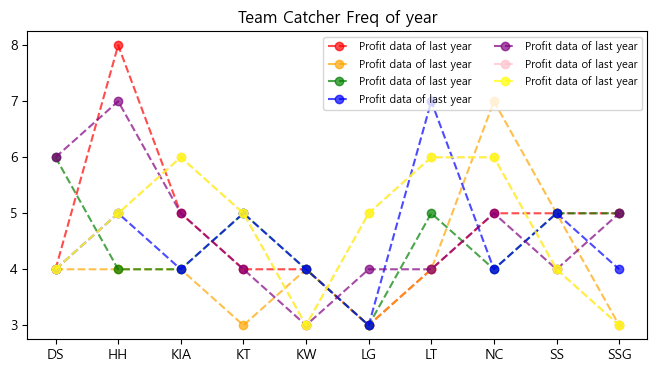

In [147]:
fig = plt.figure(figsize=(8,4))

profitList = dfdf['p_team'].tolist()
yearList  = dfdf[2017].tolist()
yearList1 = dfdf[2018].tolist()
yearList2 = dfdf[2019].tolist()
yearList3 = dfdf[2020].tolist()
yearList4 = dfdf[2021].tolist()
yearList5 = dfdf[2022].tolist()

plt.plot(profitList, yearList, label = 'Profit data of last year', color='red', marker='o', markerfacecolor='red', linestyle='--', linewidth=1.5, alpha=0.7)
plt.plot(profitList, yearList1, label = 'Profit data of last year', color='orange', marker='o', markerfacecolor='orange', linestyle='--', linewidth=1.5, alpha=0.7)
plt.plot(profitList, yearList3, label = 'Profit data of last year', color='green', marker='o', markerfacecolor='green', linestyle='--', linewidth=1.5, alpha=0.7)
plt.plot(profitList, yearList4, label = 'Profit data of last year', color='blue', marker='o', markerfacecolor='blue', linestyle='--', linewidth=1.5, alpha=0.7)
plt.plot(profitList, yearList5, label = 'Profit data of last year', color='purple', marker='o', markerfacecolor='purple', linestyle='--', linewidth=1.5, alpha=0.7)
plt.plot(profitList, yearList2, label = 'Profit data of last year', color='pink', marker='o', markerfacecolor='pink', linestyle='--', linewidth=1.5, alpha=0.7)
plt.plot(profitList, yearList2, label = 'Profit data of last year', color='yellow', marker='o', markerfacecolor='yellow', linestyle='--', linewidth=1.5, alpha=0.7)
# plt.plot(profitList, yearList1, label = 'Profit data of last year', color='orange', marker='o', markerfacecolor='orange', linestyle='--', linewidth=1.5)
      
plt.xlabel('')
plt.ylabel('')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.title('Team Catcher Freq of year')
plt.xticks(profitList)
plt.yticks()
plt.show()

*년도별 팀순위(KBO)*
- 2017 | KIA, DS, LT, NC, SSG | LG, KW, HH, SS, KT |
- 2018 | SSG, DS, HH, KW, KIA | SSG, NC, LT, KIA, HH |
- 2019 | DS, KW, SSG, LG, NC | KT, KIA, SS, HH, LT |
- 2020 | NC, DS, KT, LG, KW | KIA, LT, SS, SK , HH |
- 2021 | KT, DS, SS, LG, KW | SSG, NC, LT, KIA, HH |
- 2022 | SSG, KW, LG, KT, KIA | NC, SS, LT, DS, HH |

---
# 6️⃣ Design layout and basic setting with Matplotlib
- [Creative report designed only with Matplotlib, without office software](https://towardsdatascience.com/creative-report-designed-only-with-matplotlib-without-office-software-9d8b5af4f9c2)

(0.0, 1.0, 0.0, 1.0)

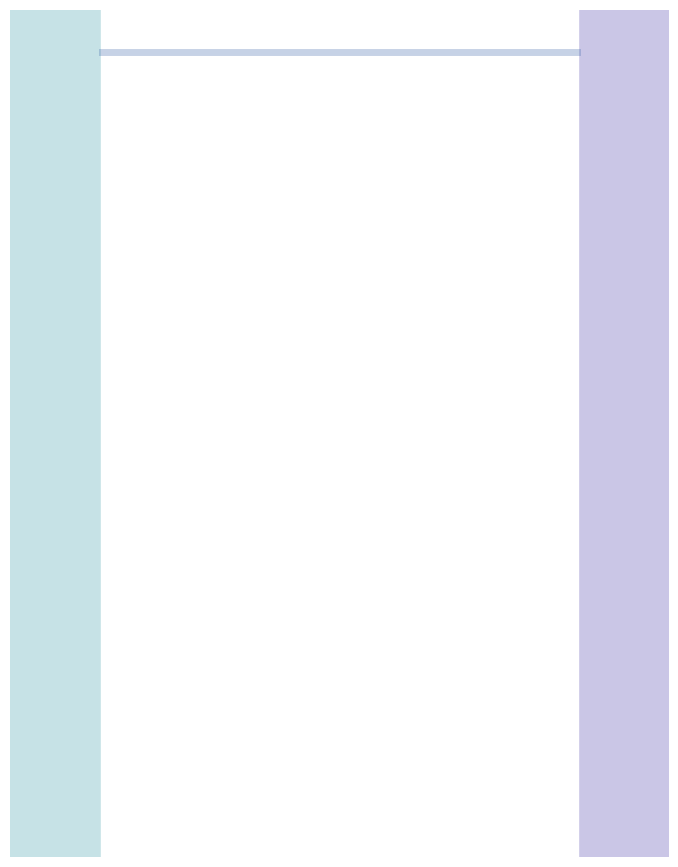

In [148]:
import matplotlib.pyplot as plt
# set font
# set A4 paper
fig, ax = plt.subplots(figsize=(8.5, 11))  
# Decorative Lines
ax.axvline(x=.01, ymin=0, ymax=1, color='#44A0AD', alpha=.3, linewidth=120)
plt.axvline(x=.99, color='#5244AD', alpha=.3, linewidth=120)
plt.axhline(y=.95, xmin=.14, xmax=.86, color='#446BAD', linewidth=5,alpha=.3)

# set background color
ax.set_facecolor('white')

# remove axes
plt.axis('off')

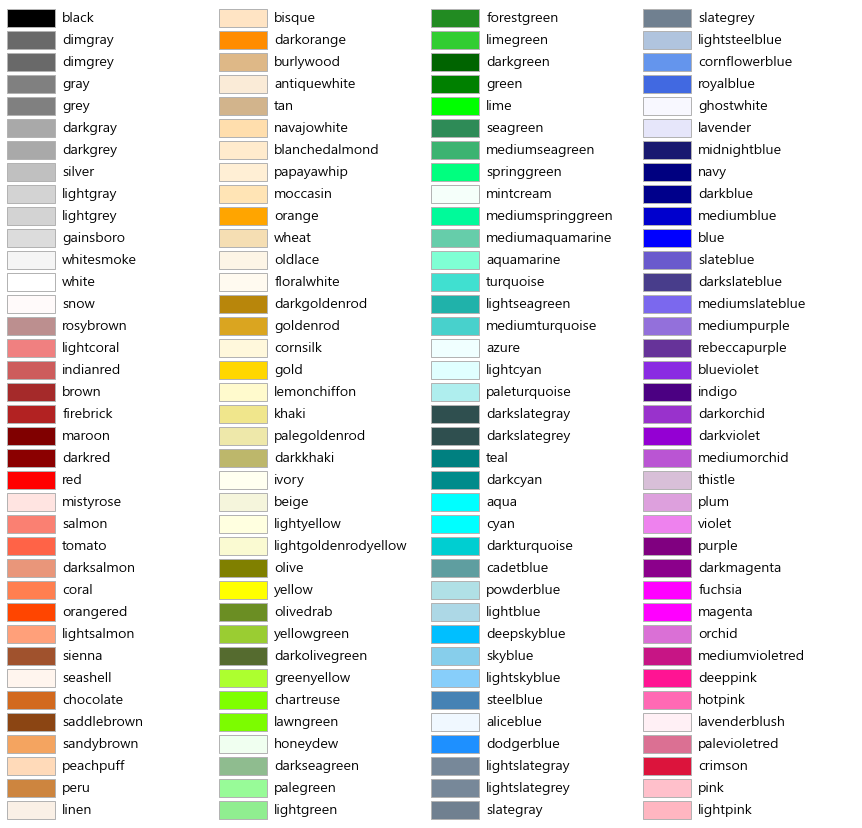

In [149]:
import math

from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * 4 + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * 4)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

plot_colortable(mcolors.CSS4_COLORS)
plt.show()

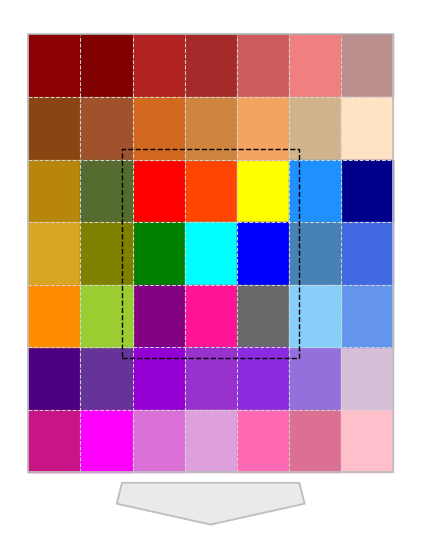

In [150]:
fig = plt.figure(figsize = (7,7))
ax = plt.subplot(111)

pitch_divisions(ax, grids = True)

zone_colors = {
    'zone_1': 'red', 'zone_2': 'orangered', 'zone_3': 'yellow'
    , 'zone_4': 'green', 'zone_5': 'cyan', 'zone_6': 'blue'
    , 'zone_7': 'purple', 'zone_8': 'deeppink', 'zone_9': 'dimgray'
    
    , 'zone_26': 'darkred', 'zone_27': 'maroon', 'zone_28': 'firebrick', 'zone_29': 'brown', 'zone_30': 'indianred', 'zone_31': 'lightcoral', 'zone_32': 'rosybrown'
    , 'zone_33': 'saddlebrown', 'zone_10': 'sienna', 'zone_11': 'chocolate', 'zone_12': 'peru', 'zone_13': 'sandybrown', 'zone_14': 'tan', 'zone_38': 'bisque'
    
    , 'zone_37': 'indigo', 'zone_21': 'rebeccapurple', 'zone_22': 'darkviolet', 'zone_23': 'darkorchid', 'zone_24': 'blueviolet', 'zone_25': 'mediumpurple', 'zone_42': 'thistle'
    , 'zone_43': 'mediumvioletred', 'zone_44': 'magenta', 'zone_45': 'orchid', 'zone_46': 'plum', 'zone_47': 'hotpink', 'zone_48': 'palevioletred', 'zone_49': 'pink'
    
    , 'zone_34': 'darkgoldenrod', 'zone_35': 'goldenrod', 'zone_36': 'darkorange', 'zone_15': 'darkolivegreen', 'zone_16': 'olive', 'zone_17': 'yellowgreen'
    , 'zone_39': 'darkblue', 'zone_40': 'royalblue', 'zone_41': 'cornflowerblue', 'zone_18': 'dodgerblue', 'zone_19': 'steelblue', 'zone_20': 'lightskyblue'
}

for zone in zone_colors:
    x_lim = [zone_areas101[zone]['x_lower_bound'], zone_areas101[zone]['x_upper_bound']]
    y1 = zone_areas101[zone]['y_lower_bound']; y2 = zone_areas101[zone]['y_upper_bound']
    ax.fill_between(x=x_lim, y1=y1, y2=y2, color=zone_colors[zone], zorder=-1)

<AxesSubplot: >

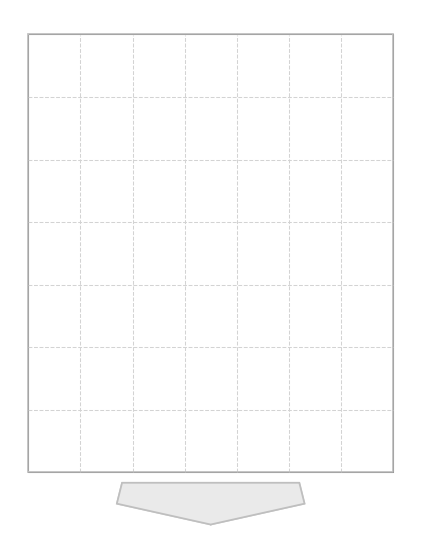

In [156]:
fig = plt.figure(figsize = (7,7))
ax = plt.subplot(111)

pitch_divisions(ax, grids = True)